<a href="https://colab.research.google.com/github/ivoryRabbit/NIMS_PLIM/blob/gh-pages/1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA(Exploratory Data Analysis)

## 0. 목차

- [1. 패키지 불러오기](#1.-패키지-불러오기)
    - [1.1 Check versions](#1.1-Check-versions)
    - [1.2 Import library](#1.2-Import-library)
- [2. 데이터 불러오기](#2.-데이터-불러오기)
- [3. 데이터 시각화](#3.-데이터-시각화)
    - [3.1 Test set samples](#3.1-Test-set-samples)
    - [3.2 Train set samples](#3.2-Train-set-samples)
- [4. 데이터 정제](#4.-데이터-정제)
    - [4.1 Outliers](#4.1-Outliers)
    - [4.2 Too many zeros](#4.2-Too-many-zeros)
    - [4.3 Temporal shocks](#4.3-Temporal-shocks)
    - [4.4 Duplications](#4.4-Duplications)
    - [4.5 Anormal values](#4.5-Anormal-values)
    - [4.6 Out of cluster](#4.6-Out-of-cluster)
- [5. Feature selection](#5.-Feature-selection)
    - [5.1 Seasonality](#5.1-Seasonality)
    - [5.2 Autocorrelation](#5.2-Autocorrelation)
    - [5.3 Correlation](#5.3-Correlation)
    - [5.4 Feature importance](#5.4-Feature-importance)
    - [5.5 Trends by year](#5.5-Trends-by-year)
    - [5.6 Before preprocessing](#5.6-Before-preprocessing)
    - [5.7 After preprocessing](#5.7-After-preprocessing)
    - [5.8 Trends by month](#5.8-Trends-by-month)
- [6. 데이터 저장](#6.-데이터-저장)

## 1. 패키지 불러오기

### 1.1 Check versions

In [1]:
# pip freeze

### 1.2 Import library

In [ ]:
# base
import pandas as pd
import numpy as np
import scipy as sp
import glob, re, gc, os
np.random.seed(777)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Panel, Tabs, HoverTool
from bokeh.io import output_file, output_notebook
from bokeh.resources import INLINE
output_notebook(INLINE)

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# ML
from sklearn.ensemble import IsolationForest,RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

# time series
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

## 2. 데이터 불러오기

- data 폴더 속에 train.csv, test.csv, sample_submission.csv가 있어야 작동합니다.

In [ ]:
display(glob.glob('data/*'))

['data/sample_submission.csv',
 'data/train_clean_2.csv',
 'data/train_clean.csv',
 'data/test.csv',
 'data/train.csv',
 'data/test_duple_info.csv',
 'data/train_duple_info.csv']

In [ ]:
train = pd.read_csv('data/train.csv', index_col = 'id')
print(train.shape)
train.head()

(78587, 125)


2009-01  2009-02  2009-03  2009-04  2009-05  2009-06  2009-07  2009-08  \
id                                                                           
0     26.68    11.86    19.77    14.83     7.90     2.96     5.93     4.94   
1    107.73    77.09    79.09     4.94    48.44    22.74    33.61    23.72   
2     94.88    90.93    78.10    66.24    38.55    25.70    27.68    26.69   
3      0.00     0.00   149.29    51.41     6.92     8.89     2.96     2.96   
4     97.85    97.85    70.19    60.31    31.63    25.70    20.76    22.74   

    2009-09  2009-10  ...  2018-08  2018-09  2018-10  2018-11  2018-12  \
id                    ...                                                
0      4.94     4.94  ...     1.97     0.98     2.96     4.94     6.91   
1     23.72    25.70  ...    11.85    11.85    19.76    22.73    38.54   
2     18.78    15.81  ...     0.00     0.00     0.00     0.00    81.04   
3      1.97     3.95  ...     0.00     0.00     5.92    26.68    74.12   
4     20.76    20.76  ...     8.89     8.89    16.80    22.73    20.75   

    2019-01  2019-02  2019-03  2019-04  2019-05  
id                                               
0      9.88     0.00     2.96     7.90     4.94  
1    145.28    56.33    62.26    58.31    32.61  
2    130.45    71.15     0.00     0.00     0.00  
3    158.12   159.11   105.75    86.97    43.48  
4     26.68    32.61    19.76    21.74    15.81  

[5 rows x 125 columns]

In [ ]:
test = pd.read_csv('data/test.csv', index_col = 'id')
print(test.shape)
test.head()

(10000, 113)


2009-01  2009-02  2009-03  2009-04  2009-05  2009-06  2009-07  2009-08  \
id                                                                              
78587    74.13    93.89    79.09    59.32    29.66    19.77    14.83    14.83   
78588    41.51    53.37    43.50    34.60    25.70    17.79    11.86    11.86   
78589    82.03    86.97    81.07    58.33    41.52    19.77     9.88    12.85   
78590    89.94    80.06   107.76    62.28    25.70    20.76    19.77    18.78   
78591    17.79    19.76    20.76    26.69    28.67    32.62    20.76     9.88   

       2009-09  2009-10  ...  2017-08  2017-09  2017-10  2017-11  2017-12  \
id                       ...                                                
78587    14.83    10.87  ...    12.84     9.88    14.82    27.66    66.20   
78588     9.88    10.87  ...    10.86     8.89     9.88    23.71    44.46   
78589     9.88    14.83  ...     7.90     7.90    10.86    20.75    59.28   
78590    30.64     0.00  ...     7.90     9.88    12.84     8.89    34.58   
78591    10.87    11.86  ...    14.82    13.83    15.80    23.71    60.27   

       2018-01  2018-02  2018-03  2018-04  2018-05  
id                                                  
78587    83.98    93.86    79.06    53.36    33.60  
78588    82.01    92.88    79.06    55.34    26.68  
78589    81.02    92.88    69.18    38.54    14.82  
78590    64.22    64.22    64.23    49.41    39.53  
78591    83.98    82.01    88.94    57.32    22.73  

[5 rows x 113 columns]

In [ ]:
sample_submission = pd.read_csv('data/sample_submission.csv', index_col = 'id')
print(sample_submission.shape)
sample_submission.head()

(10000, 12)


2018-06  2018-07  2018-08  2018-09  2018-10  2018-11  2018-12  2019-01  \
id                                                                              
78587      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
78588      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
78589      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
78590      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
78591      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

       2019-02  2019-03  2019-04  2019-05  
id                                         
78587      0.0      0.0      0.0      0.0  
78588      0.0      0.0      0.0      0.0  
78589      0.0      0.0      0.0      0.0  
78590      0.0      0.0      0.0      0.0  
78591      0.0      0.0      0.0      0.0

In [ ]:
print(f'train data feature 개수 : {train.columns.size}')
print(f'test data feature 개수 : {test.columns.size}')
print(f'target variable 개수: {train.columns.size - test.columns.size}')

pd.concat([train.columns.to_frame().agg(['min', 'max']).rename(columns = {0: 'train'}),
           test.columns.to_frame().agg(['min', 'max']).rename(columns = {0: 'test'})],
          axis = 1)

train data feature 개수 : 125
test data feature 개수 : 113
target variable 개수: 12


train     test
min  2009-01  2009-01
max  2019-05  2018-05

## 3. 데이터 시각화

- 매번 각 데이터 세트로부터 24개의 랜덤 샘플을 뽑아 시각화합니다.
- 매번 EDA를 실행하면서 불량 데이터의 유형을 발견하기도 합니다.

### 3.1 Test set samples

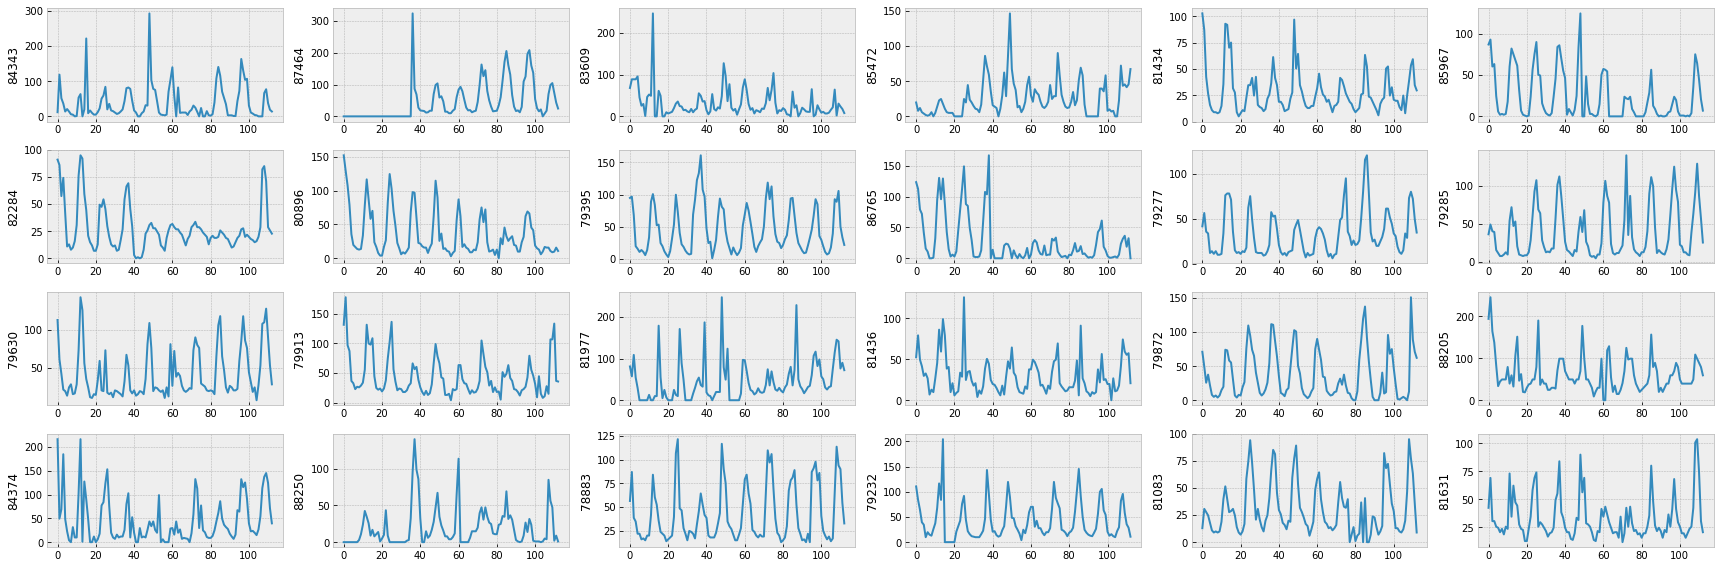

In [ ]:
ncols, nrows = 6, 4
size = (4, 2)
fig, axes = plt.subplots(nrows, ncols, figsize = (ncols * size[0], nrows * size[1]))
for r in range(nrows):
    for c in range(ncols):
        idx = c + ncols * r
        sns.lineplot(x = range(test.columns.size), y = test.sample(24).iloc[idx], ax = axes[r, c])
plt.tight_layout()

In [ ]:
p = figure(plot_width = 800, plot_height = 300)
color_list = ['aqua', 'hotpink', 'deepskyblue', 'maroon', 'olive', 'salmon']
for i in range(6):
    p.line(x = range(test.columns.size), y = test.iloc[i], line_width = 2, color = color_list[i])
show(p)

### 3.2 Train set samples

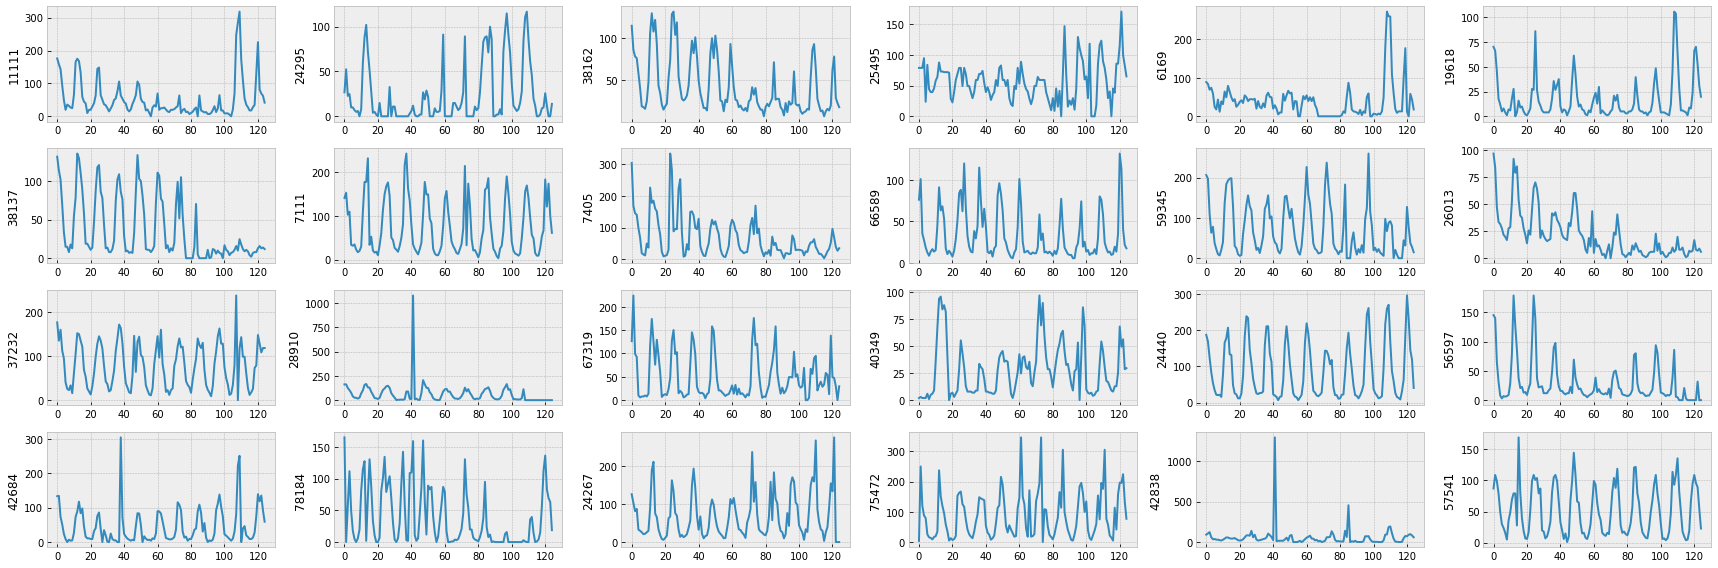

In [ ]:
ncols, nrows = 6, 4
size = (4, 2)
fig, axes = plt.subplots(nrows, ncols, figsize = (ncols * size[0], nrows * size[1]))
for r in range(nrows):
    for c in range(ncols):
        idx = c + ncols * r
        sns.lineplot(x = range(train.columns.size), y = train.sample(24).iloc[idx], ax = axes[r, c])
plt.tight_layout()

In [ ]:
p = figure(plot_width = 800, plot_height = 300)
color_list = ['aqua', 'hotpink', 'deepskyblue', 'maroon', 'olive', 'salmon']
for i in range(6):
    p.line(x = range(train.columns.size), y = train.iloc[i], line_width = 2, color = color_list[i])
show(p)

## 4. 데이터 정제

- train data는 불량데이터를 갖고 있습니다.

- test data는 불량데이터를 갖고 있지 않다고 가정합니다.

- 불량데이터의 유형
  - Case 1. 계량기 고장으로 인해 0인 경우
  - Case 2. 거주지 이전으로 인해 0인 경우
  - Case 3. 사용량을 속여 매월 일정한 경우
  - Case 4. 월별 사용량이 비정상적으로 큰 경우
  
- test set에 기반하여 train set을 전처리하는 것은 test set에 편향될 가능성이 높습니다.
- 하지만 test set이 깨끗하다고 가정한 경우, test set의 통계치(statistic)을 참고하는 정도는 괜찮다고 생각합니다.
- feature들이 모두 같은 metric space를 가지므로 scaling은 하지 않았습니다.
- 데이터 전처리 후 차원 축소를 하지 않았던 점이 조금 아쉽습니다.

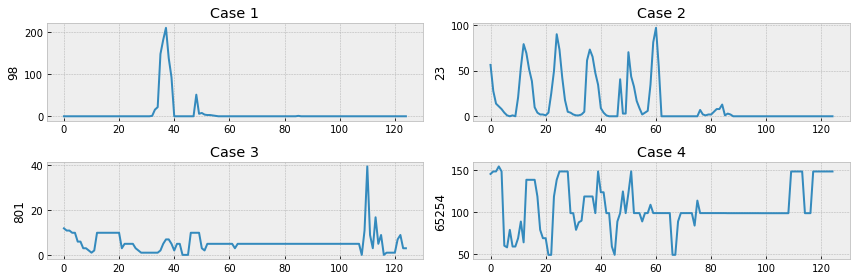

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 4))

sns.lineplot(x = range(train.columns.size), y = train.loc[98], ax = axes[0, 0])
axes[0, 0].set_title('Case 1')
sns.lineplot(x = range(train.columns.size), y = train.loc[23], ax = axes[0, 1])
axes[0, 1].set_title('Case 2')
sns.lineplot(x = range(train.columns.size), y = train.loc[801], ax = axes[1, 0])
axes[1, 0].set_title('Case 3')
sns.lineplot(x = range(train.columns.size), y = train.loc[65254], ax = axes[1, 1])
axes[1, 1].set_title('Case 4')
plt.tight_layout()

### 4.1 Outliers

- 먼저 도시가스 실수요 분포에서 너무 큰 값을 가지는 관측치를 제거하려 합니다.
- 분포가 너무 왼쪽으로 치우쳐 있기에 log값을 취해 시각화합니다.
- train set과 test set에서 전반적으로 크다고 할 수 있는 값을 찾아내어 잘라(truncate)내줍니다.

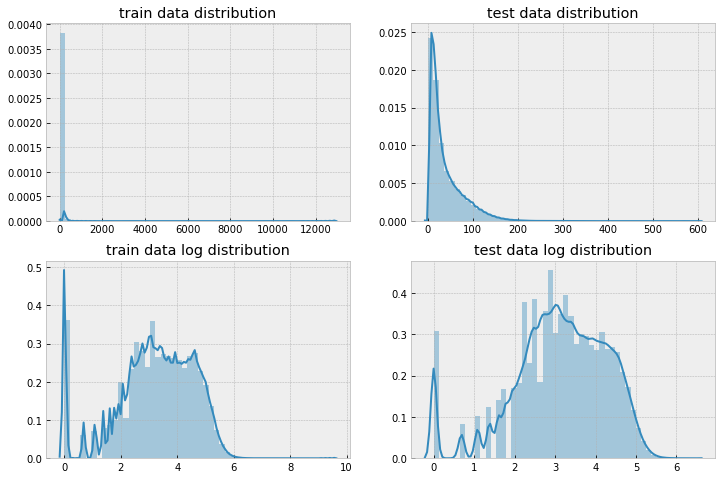

In [ ]:
train_melt, test_melt = map(lambda df: df.values.reshape(-1), (train, test))

fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 8))
sns.distplot(train_melt, ax = axes[0, 0])
axes[0, 0].set_title('train data distribution')
sns.distplot(test_melt, ax = axes[0, 1])
axes[0, 1].set_title('test data distribution')

train_melt2, test_melt2 = map(lambda x: np.log1p(x), (train_melt, test_melt))

sns.distplot(train_melt2, ax = axes[1, 0])
axes[1, 0].set_title('train data log distribution')
sns.distplot(test_melt2, ax = axes[1, 1])
axes[1, 1].set_title('test data log distribution')

plt.show()

- test set보다 확실히 꼬리가 길고 0의 개수가 많아보입니다.
- 0은 나중에 정리하기로 하고, 우선 꼬리를 자릅니다.
- 대략 630 선에서 truncate하였습니다.

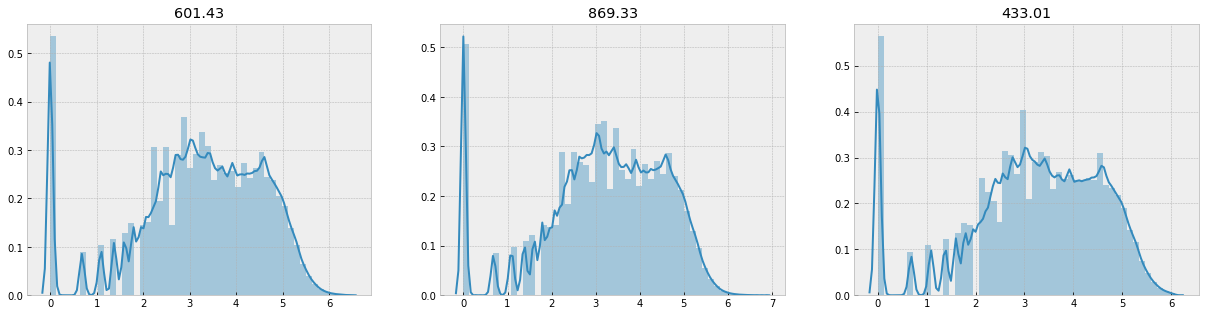

In [ ]:
use_test_max = test_melt.max()
use_percentile = np.percentile(train_melt, 99.99)
use_std =  train_melt.mean() + 6 * train_melt.std()

fig, axes = plt.subplots(ncols = 3, figsize = (21, 5))

sns.distplot(train_melt2[train_melt < use_test_max], ax = axes[0])
axes[0].set_title(round(use_test_max, 2))

sns.distplot(train_melt2[train_melt < use_percentile], ax = axes[1])
axes[1].set_title(round(use_percentile, 2))

sns.distplot(train_melt2[train_melt < use_std], ax = axes[2])
axes[2].set_title(round(use_std, 2))
plt.show()

In [ ]:
AVG = sum([use_test_max, use_percentile, use_std]) / 3
MAX = max([use_test_max, use_percentile, use_std])
print('Average:', AVG)
print('Max:', MAX)

Average: 634.5886171387472
Max: 869.3288599994034


- 이렇게 높은 수치를 갖는 관측치들을 시각화해보면 일시적인 쇼크(temporal shock)가 대부분입니다.
- 이러한 데이터는 사실 test set에도 존재하지만, 후에 사용할 gradient boosting 모델들은 이상치에 민감하므로 제거해줍니다.
- 만약 데이터가 적었다면 제거하기보단 다른 값으로 교체(replace)해주는 것도 나쁘지 않아 보입니다.

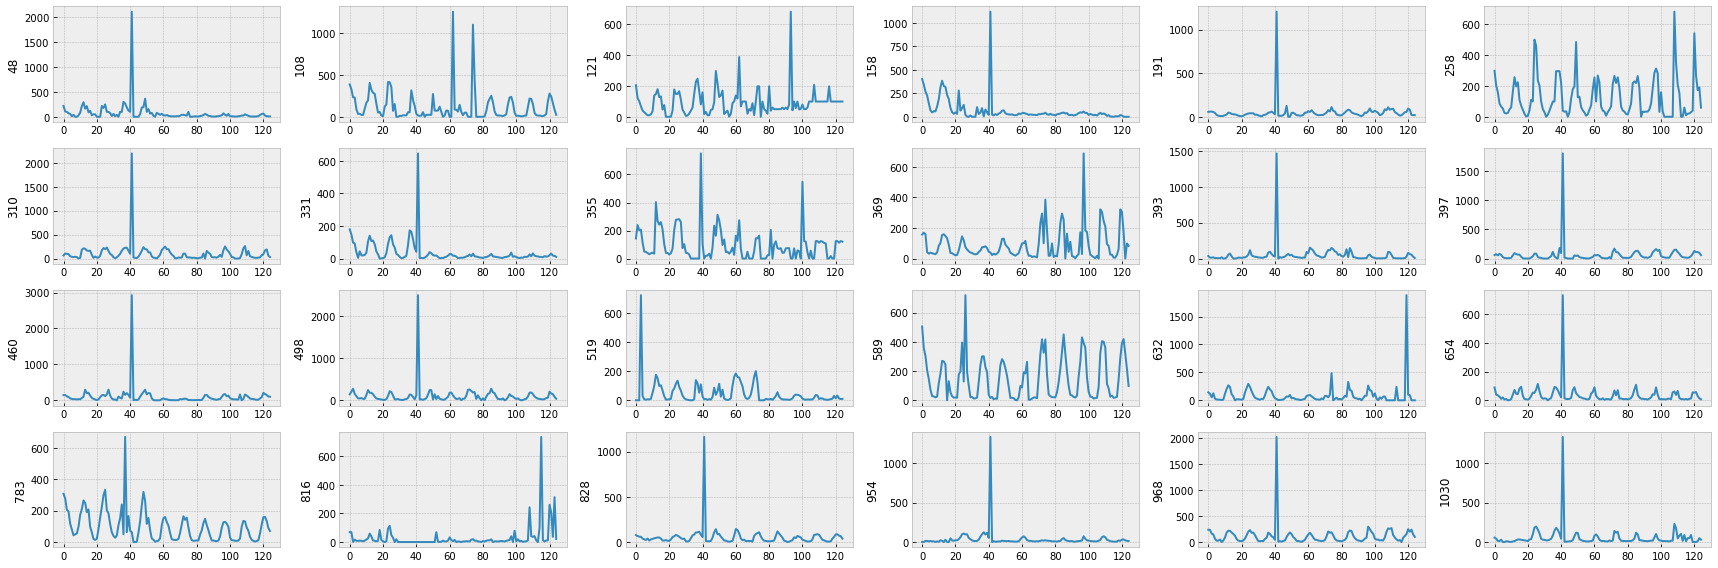

In [ ]:
ncols, nrows = 6, 4
size = (4, 2)
fig, axes = plt.subplots(nrows, ncols, figsize = (ncols * size[0], nrows * size[1]))
temp = train.loc[(train > AVG).apply(any, axis = 1)]
for r in range(nrows):
    for c in range(ncols):
        idx = c + ncols * r
        if idx >= temp.shape[0]: break
        sns.lineplot(x = range(temp.columns.size), y = temp.iloc[idx], ax = axes[r, c])
plt.tight_layout()

In [ ]:
train_clean0 = train.loc[(train < AVG).apply(all, axis = 1)]
print(train_clean0.shape)
train_clean0.head()

(76927, 125)


2009-01  2009-02  2009-03  2009-04  2009-05  2009-06  2009-07  2009-08  \
id                                                                           
0     26.68    11.86    19.77    14.83     7.90     2.96     5.93     4.94   
1    107.73    77.09    79.09     4.94    48.44    22.74    33.61    23.72   
2     94.88    90.93    78.10    66.24    38.55    25.70    27.68    26.69   
3      0.00     0.00   149.29    51.41     6.92     8.89     2.96     2.96   
4     97.85    97.85    70.19    60.31    31.63    25.70    20.76    22.74   

    2009-09  2009-10  ...  2018-08  2018-09  2018-10  2018-11  2018-12  \
id                    ...                                                
0      4.94     4.94  ...     1.97     0.98     2.96     4.94     6.91   
1     23.72    25.70  ...    11.85    11.85    19.76    22.73    38.54   
2     18.78    15.81  ...     0.00     0.00     0.00     0.00    81.04   
3      1.97     3.95  ...     0.00     0.00     5.92    26.68    74.12   
4     20.76    20.76  ...     8.89     8.89    16.80    22.73    20.75   

    2019-01  2019-02  2019-03  2019-04  2019-05  
id                                               
0      9.88     0.00     2.96     7.90     4.94  
1    145.28    56.33    62.26    58.31    32.61  
2    130.45    71.15     0.00     0.00     0.00  
3    158.12   159.11   105.75    86.97    43.48  
4     26.68    32.61    19.76    21.74    15.81  

[5 rows x 125 columns]

- 비성장적인 수치를 가지는 경우말고도 데이터 자체가 너무 큰 경우를 제거하겠습니다.
- 데이터가 무거운 경우(mean), 데이터의 분산이 큰 경우(std), 데이터의 최소값 비율이 높은 경우(prop)를 고려합니다.
- 이러한 전처리 덕분에 약간의 점수 향상이 있었습니다.

In [ ]:
pd.DataFrame(
    {'mean': np.mean(test, axis = 1),
     'std': np.std(test, axis = 1),
     'prop': np.min(test, axis = 1) / np.max(test, axis = 1)}
).describe(percentiles = [0.5, 0.68, 0.95, 0.997])

mean           std          prop
count  10000.000000  10000.000000  10000.000000
mean      37.583056     35.005845      0.010567
std       11.436672     10.456845      0.021601
min       14.404602      7.893262      0.000000
50%       37.105310     34.884168      0.000000
68%       43.687154     40.319721      0.004159
95%       56.799686     52.444781      0.055184
99.7%     61.981433     59.825250      0.130362
max       65.554425     62.592836      0.211120

In [ ]:
pd.DataFrame(
    {'mean': np.mean(train_clean0, axis = 1),
     'std': np.std(train_clean0, axis = 1),
     'prop': np.min(train_clean0, axis = 1) / np.max(train_clean0, axis = 1)}
).describe(percentiles = [0.5, 0.68, 0.95, 0.997])

mean           std          prop
count  76927.000000  76927.000000  76927.000000
mean      49.549483     45.980335      0.007257
std       25.932954     21.225524      0.017502
min        0.007840      0.087303      0.000000
50%       47.242080     44.601657      0.000000
68%       60.166080     54.368411      0.000000
95%       94.675920     82.809732      0.042583
99.7%    145.602932    124.298233      0.113345
max      238.068480    209.576131      0.374210

- 평균값이 높더라도 데이터 양상에는 딱히 이상이 없어보입니다.
- 다만 분산(혹은 표준편차)의 경우는 평균을 예측값으로 할때의 mse(혹은 rmse)이기 때문에 너무 큰 값들은 덜어내줍니다.
- 최대값에 비해 최소값의 비율이 큰 데이터는 불량데이터라 판단했습니다.

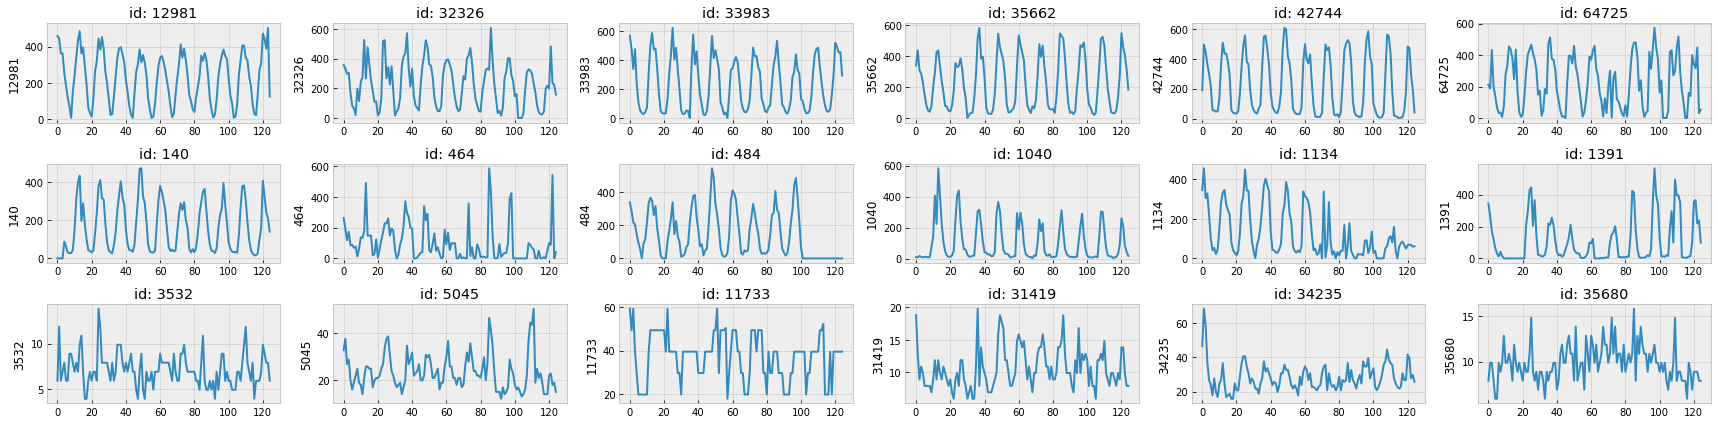

In [ ]:
ncols, nrows = 6, 3
size = (4, 2)
fig, axes = plt.subplots(nrows, ncols, figsize = (ncols * size[0], nrows * size[1]))

temp = train_clean0[np.mean(train_clean0, axis = 1) > 220]
for i in range(ncols):
    sns.lineplot(x = range(temp.columns.size), y = temp.iloc[i], ax = axes[0, i])
    axes[0, i].set_title(f'id: {temp.index[i]}')

temp = train_clean0[np.std(train_clean0, axis = 1) > 120]
for i in range(ncols):
    sns.lineplot(x = range(temp.columns.size), y = temp.iloc[i], ax = axes[1, i])
    axes[1, i].set_title(f'id: {temp.index[i]}')

temp = train_clean0[np.min(train_clean0, axis = 1) / np.max(train_clean0, axis = 1) > 0.22]
for i in range(ncols):
    sns.lineplot(x = range(temp.columns.size), y = temp.iloc[i], ax = axes[2, i])
    axes[2, i].set_title(f'id: {temp.index[i]}')

plt.tight_layout()

- 처음 이상치를 제거했던 방법에서 더 나아가 월별로 이상치를 제거해보겠습니다.
- 특히 여름철에 비정상적인 수요를 가진 경우를 제거하였습니다.
- 점수 향상이 있었습니다. 

In [ ]:
def build_month_data(df, func = np.mean):
    df_month = pd.DataFrame()
    for month in [f'{i+1:02d}' for i in range(12)]:
        temp = func(df.loc[:, df.columns[df.columns.str.contains(f'-{month}')]], axis = 1)
        df_month[f'{month}'] = temp
    return df_month

In [ ]:
test_max_mean = build_month_data(test.apply([np.max], axis = 0), np.mean)
test_max_mean

01       02       03       04      05         06         07  \
amax  362.654  433.838  411.279  403.782  99.752  95.357778  96.123333   

             08          09          10          11          12  
amax  83.601111  184.021111  198.412222  249.471111  350.111111

In [ ]:
test_max_std = build_month_data(test.apply([np.max], axis = 0), np.std)
test_max_std

01         02         03         04        05        06  \
amax  37.350067  86.382404  53.419188  79.974489  0.316095  5.320392   

            07         08        09         10         11         12  
amax  3.783288  10.976687  91.92099  69.901904  77.631856  62.981058

In [ ]:
test_max_6sigma = (test_max_mean + 6 * test_max_std).values
test_max_6sigma

array([[586.75440193, 952.13242661, 731.79413038, 883.62893494,
        101.64856953, 127.2801308 , 118.8230602 , 149.46123224,
        735.54705207, 617.82364865, 715.26224838, 727.99745746]])

In [ ]:
train_percentile = build_month_data(train_clean0, np.max).apply(lambda x: np.percentile(x, 99), axis = 0).values
train_percentile

array([445.8766, 459.2884, 411.34  , 374.6296, 297.47  , 265.87  ,
       185.9748, 143.4374, 120.5696, 138.4248, 211.6   , 333.1122])

In [ ]:
build_month_data(train_clean0.apply([np.max], axis = 0), np.mean)

01      02          03          04          05       06  \
amax  622.046364  630.05  618.993636  611.896364  603.446364  600.984   

           07       08       09       10      11       12  
amax  589.952  577.398  486.038  544.966  544.47  602.117

In [ ]:
pd.DataFrame((test_max_6sigma + train_percentile) / 2, columns = range(1, 13))

1           2           3           4           5           6   \
0  516.315501  705.710413  571.567065  629.129267  199.559285  196.575065   

          7           8           9           10          11          12  
0  152.39893  146.449316  428.058326  378.124224  463.431124  530.554829

- 시각화에서는 정상적인 시계열 데이터처럼 보입니다.
- 그러나 겨울철보다 8월 같은 여름철에 더 수요가 높은 경우가 꽤나 있습니다.

5719


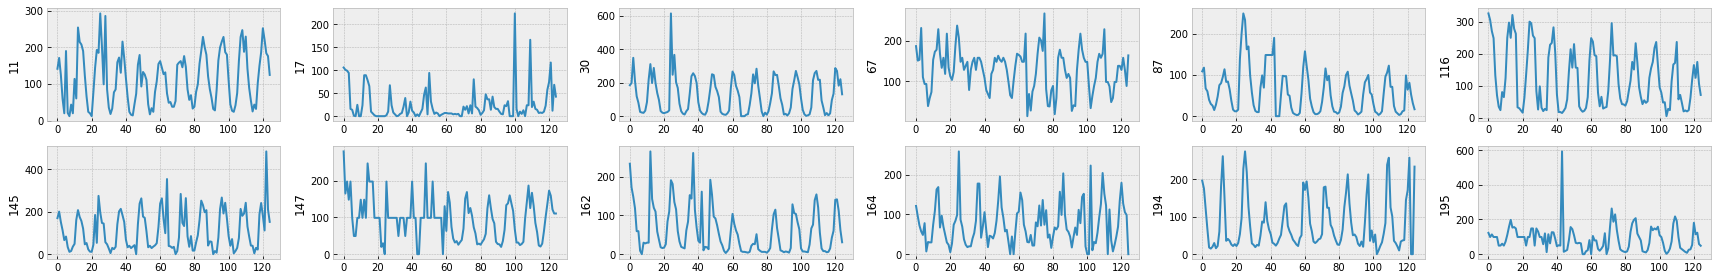

In [ ]:
ncols, nrows = 6, 2
size = (4, 2)
fig, axes = plt.subplots(nrows, ncols, figsize = (ncols * size[0], nrows * size[1]))
temp = train_clean0[np.any(build_month_data(train_clean0, np.max) > (test_max_6sigma + train_percentile) / 2, axis = 1)]
print(temp.shape[0])
for r in range(nrows):
    for c in range(ncols):
        idx = c + ncols * r
        if idx >= temp.shape[0]: break
        sns.lineplot(x = range(temp.columns.size), y = temp.iloc[idx], ax = axes[r, c])
plt.tight_layout()

- 이제는 train set과 test set의 최소값을 살펴보았습니다.
- 참고로 이 전처리는 제출 때 적용하지 않았습니다.

In [ ]:
test.min(axis = 1).describe(percentiles = [0.5, 0.68, 0.95, 0.997])

count    10000.000000
mean         1.484866
std          2.799902
min          0.000000
50%          0.000000
68%          0.980000
95%          7.900000
99.7%       14.820000
max         22.730000
dtype: float64

In [ ]:
train_clean0.min(axis = 1).describe(percentiles = [0.5, 0.68, 0.95, 0.997])

count    76927.000000
mean         1.290135
std          2.920053
min          0.000000
50%          0.000000
68%          0.000000
95%          7.900000
99.7%       17.780000
max         49.420000
dtype: float64

36


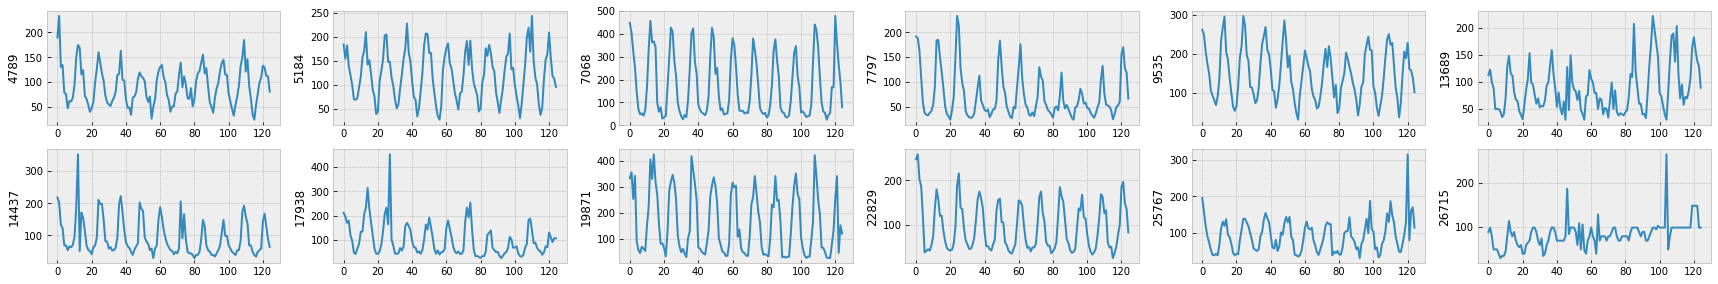

In [ ]:
ncols, nrows = 6, 2
size = (4, 2)
fig, axes = plt.subplots(nrows, ncols, figsize = (ncols * size[0], nrows * size[1]))
temp = train_clean0[train_clean0.min(axis = 1) > 23]
print(temp.shape[0])
for r in range(nrows):
    for c in range(ncols):
        idx = c + ncols * r
        if idx >= temp.shape[0]: break
        sns.lineplot(x = range(temp.columns.size), y = temp.iloc[idx], ax = axes[r, c])
plt.tight_layout()

In [ ]:
train_clean1 = train_clean0[
    (np.std(train_clean0, axis = 1) < 120) & 
    (np.min(train_clean0, axis = 1) / np.max(train_clean0, axis = 1) < 0.22) &
    (np.all(build_month_data(train_clean0, np.max) < (test_max_6sigma + train_percentile) / 2, axis = 1))
    #(train_clean0.min(axis = 1) < 23)
]
print(train_clean1.shape)
train_clean1.head()

(71091, 125)


2009-01  2009-02  2009-03  2009-04  2009-05  2009-06  2009-07  2009-08  \
id                                                                           
0     26.68    11.86    19.77    14.83     7.90     2.96     5.93     4.94   
1    107.73    77.09    79.09     4.94    48.44    22.74    33.61    23.72   
2     94.88    90.93    78.10    66.24    38.55    25.70    27.68    26.69   
3      0.00     0.00   149.29    51.41     6.92     8.89     2.96     2.96   
4     97.85    97.85    70.19    60.31    31.63    25.70    20.76    22.74   

    2009-09  2009-10  ...  2018-08  2018-09  2018-10  2018-11  2018-12  \
id                    ...                                                
0      4.94     4.94  ...     1.97     0.98     2.96     4.94     6.91   
1     23.72    25.70  ...    11.85    11.85    19.76    22.73    38.54   
2     18.78    15.81  ...     0.00     0.00     0.00     0.00    81.04   
3      1.97     3.95  ...     0.00     0.00     5.92    26.68    74.12   
4     20.76    20.76  ...     8.89     8.89    16.80    22.73    20.75   

    2019-01  2019-02  2019-03  2019-04  2019-05  
id                                               
0      9.88     0.00     2.96     7.90     4.94  
1    145.28    56.33    62.26    58.31    32.61  
2    130.45    71.15     0.00     0.00     0.00  
3    158.12   159.11   105.75    86.97    43.48  
4     26.68    32.61    19.76    21.74    15.81  

[5 rows x 125 columns]

### 4.2 Too many zeros

- 너무 많은 0을 가진 관측치는 결측을 가진 불량데이터이며, 모델을 학습시키는데 악영향을 주기 때문에 제거해줍니다.
- 도시가스를 주로 사용할 것 같은 12월 ~ 4월 사이 데이터가 0인 경우를 유심있게 봅니다.
- 우리가 예측할 target variable에 0이 많이 껴있는 경우도 제거합니다.

In [ ]:
print(f'train data의 최대 0 개수: {np.max(np.sum(train_clean1 == 0, axis = 1))}')
print(f'test data의 최대 0 개수: {np.max(np.sum(test == 0, axis = 1))}')

train data의 최대 0 개수: 124
test data의 최대 0 개수: 40


In [ ]:
test_missing_info = test.assign(
    zeros = lambda x: np.sum(x == 0, axis = 1),
    zeros1 = lambda x : np.sum(x.loc[:, '2017-12':'2018-04'] == 0, axis = 1),
    zeros2 = lambda x : np.sum(x.loc[:, '2016-12':'2017-04'] == 0, axis = 1),
    zeros3 = lambda x : np.sum(x.loc[:, '2015-12':'2016-04'] == 0, axis = 1),
    zeros4 = lambda x : np.sum(x.loc[:, '2014-12':'2015-04'] == 0, axis = 1),
    zeros5 = lambda x : np.sum(x.loc[:, '2013-12':'2014-04'] == 0, axis = 1),
    zeros6 = lambda x : np.sum(x.loc[:, '2012-12':'2013-04'] == 0, axis = 1)
).filter(items = ['zeros', 'zeros1', 'zeros2', 'zeros3', 'zeros4', 'zeros5', 'zeros6'])
test_missing_info.describe(percentiles = [0.5, 0.68, 0.95, 0.99])

zeros        zeros1        zeros2        zeros3        zeros4  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       4.439500      0.164200      0.141500      0.160800      0.157400   
std        6.508316      0.692883      0.620094      0.643572      0.647817   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        2.000000      0.000000      0.000000      0.000000      0.000000   
68%        4.000000      0.000000      0.000000      0.000000      0.000000   
95%       19.000000      1.000000      1.000000      1.000000      1.000000   
99%       30.000000      5.000000      4.000000      4.000000      4.000000   
max       40.000000      5.000000      5.000000      5.000000      5.000000   

             zeros5        zeros6  
count  10000.000000  10000.000000  
mean       0.166600      0.136200  
std        0.658246      0.584366  
min        0.000000      0.000000  
50%        0.000000      0.000000  
68%        0.000000      0.000000  
95%        1.000000      1.000000  
99%        4.000000      3.000000  
max        5.000000      5.000000

In [ ]:
test_missing_info.\
agg(lambda x: np.mean(x) + 6*np.std(x)).to_frame().rename(columns = {0: '6 sigma'})

6 sigma
zeros   43.487443
zeros1   4.321288
zeros2   3.861876
zeros3   4.022038
zeros4   4.044109
zeros5   4.115878
zeros6   3.642221

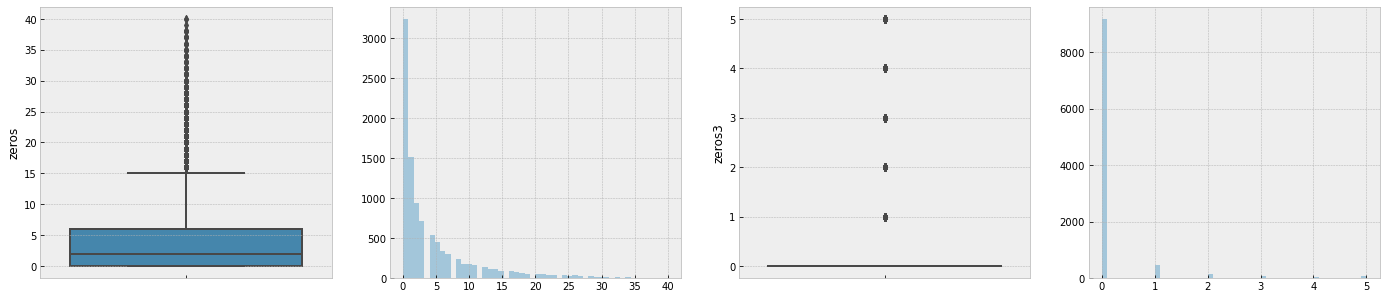

In [ ]:
fig, axes = plt.subplots(ncols = 4, figsize = (24, 5))
sns.boxplot(y = 'zeros', data = test_missing_info, ax = axes[0])
sns.distplot(test_missing_info.zeros.values, kde = False, ax = axes[1])
sns.boxplot(y = 'zeros3', data = test_missing_info, ax = axes[2])
sns.distplot(test_missing_info.zeros3.values, kde = False, ax = axes[3])
plt.show()

- 12월부터 4월 사이에서 0이 얼마나 등장하는지 확인합니다.

In [ ]:
train_missing_info = train.assign(
    x_zeros = lambda x: np.sum(x.loc[:, :'2018-05'] == 0, axis = 1),
    zeros1 = lambda x : np.sum(x.loc[:, '2017-12':'2018-04'] == 0, axis = 1),
    zeros2 = lambda x : np.sum(x.loc[:, '2016-12':'2017-04'] == 0, axis = 1),
    zeros3 = lambda x : np.sum(x.loc[:, '2015-12':'2016-04'] == 0, axis = 1),
    zeros4 = lambda x : np.sum(x.loc[:, '2014-12':'2015-04'] == 0, axis = 1),
    zeros5 = lambda x : np.sum(x.loc[:, '2013-12':'2014-04'] == 0, axis = 1),
    zeros6 = lambda x : np.sum(x.loc[:, '2012-12':'2013-04'] == 0, axis = 1),
    y_zeros = lambda x: np.sum(x.loc[:, '2018-12': '2019-04'] == 0, axis = 1)
).filter(items = ['x_zeros', 'zeros1', 'zeros2', 'zeros3', 'zeros4', 'zeros5', 'zeros6', 'y_zeros'])
train_missing_info.describe(percentiles = [0.5, 0.68, 0.95, 0.99])

x_zeros        zeros1        zeros2        zeros3        zeros4  \
count  78587.000000  78587.000000  78587.000000  78587.000000  78587.000000   
mean       7.569522      0.304465      0.296385      0.308842      0.301615   
std       14.728145      1.021130      0.992301      1.001622      0.991591   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        2.000000      0.000000      0.000000      0.000000      0.000000   
68%        5.000000      0.000000      0.000000      0.000000      0.000000   
95%       34.000000      3.000000      2.000000      2.000000      2.000000   
99%       84.000000      5.000000      5.000000      5.000000      5.000000   
max      113.000000      5.000000      5.000000      5.000000      5.000000   

             zeros5        zeros6       y_zeros  
count  78587.000000  78587.000000  78587.000000  
mean       0.294960      0.249698      0.330678  
std        0.965353      0.890880      1.060483  
min        0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000  
68%        0.000000      0.000000      0.000000  
95%        2.000000      2.000000      3.000000  
99%        5.000000      5.000000      5.000000  
max        5.000000      5.000000      5.000000

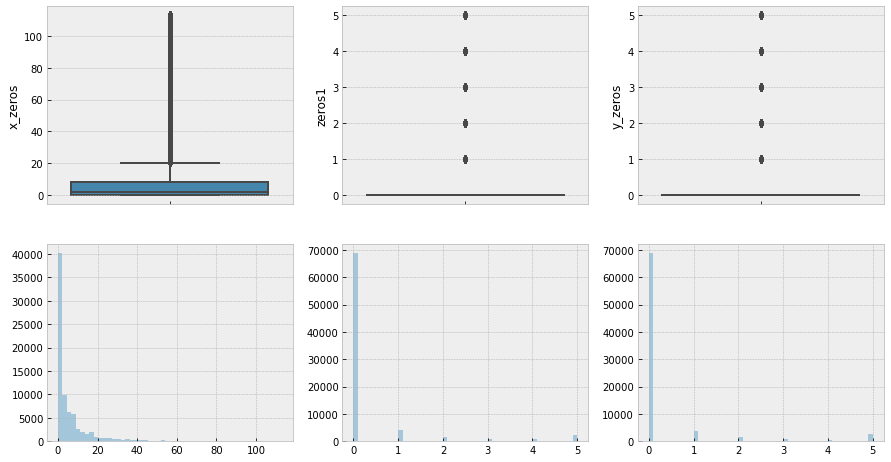

In [ ]:
fig, axes = plt.subplots(ncols = 3, nrows = 2, figsize = (15, 8))
sns.boxplot(y = 'x_zeros', data = train_missing_info, ax = axes[0, 0])
sns.distplot(train_missing_info.x_zeros.values, kde = False, ax = axes[1, 0])
sns.boxplot(y = 'zeros1', data = train_missing_info, ax = axes[0, 1])
sns.distplot(train_missing_info.zeros3.values, kde = False, ax = axes[1, 1])
sns.boxplot(y = 'y_zeros', data = train_missing_info, ax = axes[0, 2])
sns.distplot(train_missing_info.y_zeros.values, kde = False, ax = axes[1, 2])
plt.show()

- 0이 많은 데이터를 시각화해보면 이상하게 생기긴 했습니다.

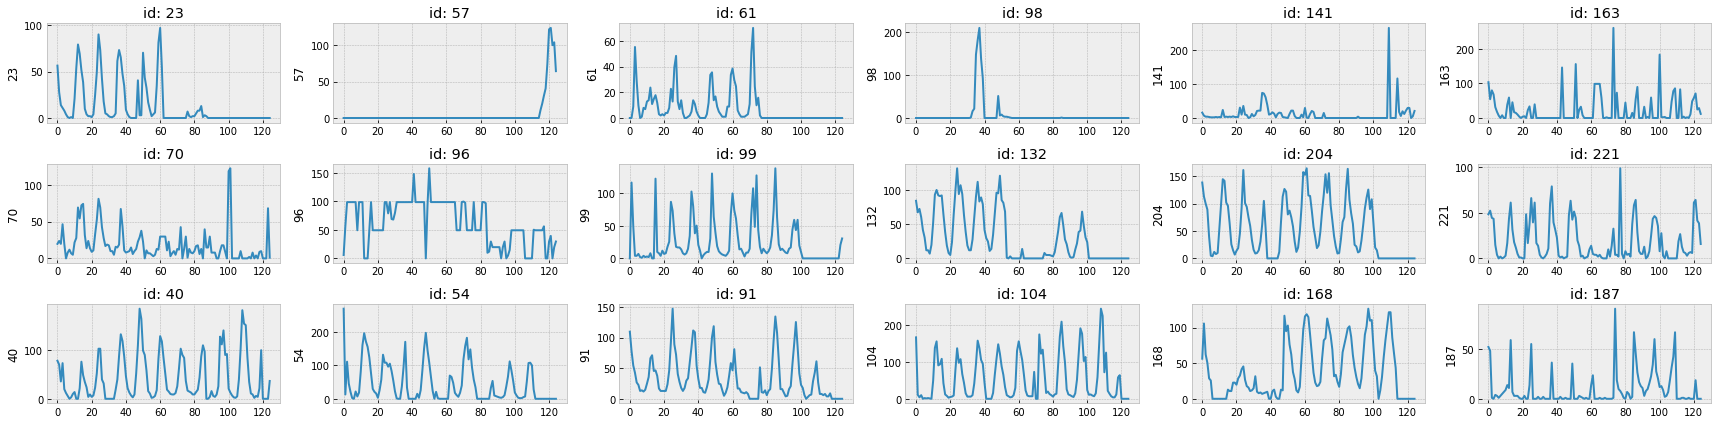

In [ ]:
ncols, nrows = 6, 3
size = (4, 2)
fig, axes = plt.subplots(nrows, ncols, figsize = (ncols * size[0], nrows * size[1]))

temp = train_clean1.loc[train_missing_info.query('x_zeros > 43').index].dropna(axis = 0)
for i in range(ncols):
    sns.lineplot(x = range(temp.columns.size), y = temp.iloc[i], ax = axes[0, i])
    axes[0, i].set_title(f'id: {temp.index[i]}')

temp = train_clean1.loc[train_missing_info.query('x_zeros <= 43 & zeros1 > 3').index].dropna(axis = 0)
for i in range(ncols):
    sns.lineplot(x = range(temp.columns.size), y = temp.iloc[i], ax = axes[1, i])
    axes[1, i].set_title(f'id: {temp.index[i]}')

temp = train_clean1.loc[train_missing_info.query('x_zeros <= 43 & zeros1 <= 3 & y_zeros > 3').index].dropna(axis = 0)
for i in range(ncols):
    sns.lineplot(x = range(temp.columns.size), y = temp.iloc[i], ax = axes[2, i])
    axes[2, i].set_title(f'id: {temp.index[i]}')

plt.tight_layout()

- 애초에 target variable이 0인 데이터를 예측하고자 하는 것이 아니므로 과감하게 제거합니다.
- 약 1만개나 되는 데이터가 제거되었습니다.

In [ ]:
train_clean2 = train_clean1.\
    loc[train_missing_info.query(
        'x_zeros <= 43 & zeros1 <= 3 & zeros2 <= 3 & zeros3 <= 3 & zeros4 <= 3 & zeros5 <= 3 & zeros6 <= 3 & y_zeros <= 3'
    ).index].\
    dropna(axis = 0)
print(train_clean2.shape)
train_clean2.head()

(62770, 125)


2009-01  2009-02  2009-03  2009-04  2009-05  2009-06  2009-07  2009-08  \
id                                                                           
0     26.68    11.86    19.77    14.83     7.90     2.96     5.93     4.94   
1    107.73    77.09    79.09     4.94    48.44    22.74    33.61    23.72   
2     94.88    90.93    78.10    66.24    38.55    25.70    27.68    26.69   
3      0.00     0.00   149.29    51.41     6.92     8.89     2.96     2.96   
4     97.85    97.85    70.19    60.31    31.63    25.70    20.76    22.74   

    2009-09  2009-10  ...  2018-08  2018-09  2018-10  2018-11  2018-12  \
id                    ...                                                
0      4.94     4.94  ...     1.97     0.98     2.96     4.94     6.91   
1     23.72    25.70  ...    11.85    11.85    19.76    22.73    38.54   
2     18.78    15.81  ...     0.00     0.00     0.00     0.00    81.04   
3      1.97     3.95  ...     0.00     0.00     5.92    26.68    74.12   
4     20.76    20.76  ...     8.89     8.89    16.80    22.73    20.75   

    2019-01  2019-02  2019-03  2019-04  2019-05  
id                                               
0      9.88     0.00     2.96     7.90     4.94  
1    145.28    56.33    62.26    58.31    32.61  
2    130.45    71.15     0.00     0.00     0.00  
3    158.12   159.11   105.75    86.97    43.48  
4     26.68    32.61    19.76    21.74    15.81  

[5 rows x 125 columns]

### 4.3 Temporal shocks

- mean, std를 했으니 자연스럽게 skew와 kurtosis를 봅시다.
- skew가 높더라도 target variable과 가까운 feature들이 정상이라면 괜찮다고 생각했습니다.
- kurtosis가 높은 관측치들은 모델을 학습시키는데 이상치로써 악영향을 준다고 판단했습니다.

In [ ]:
test.apply(sp.stats.kurtosis, axis = 1).describe(percentiles = [0.5, 0.95, 0.997])

count    10000.000000
mean         2.475216
std          4.303482
min         -1.482243
50%          1.269194
95%          9.499448
99.7%       30.873940
max         74.270024
dtype: float64

In [ ]:
test.apply(sp.stats.skew, axis = 1).describe(percentiles = [0.5, 0.95, 0.997])

count    10000.000000
mean         1.477745
std          0.687647
min         -1.110765
50%          1.354105
95%          2.733636
99.7%        4.664652
max          8.062654
dtype: float64

13


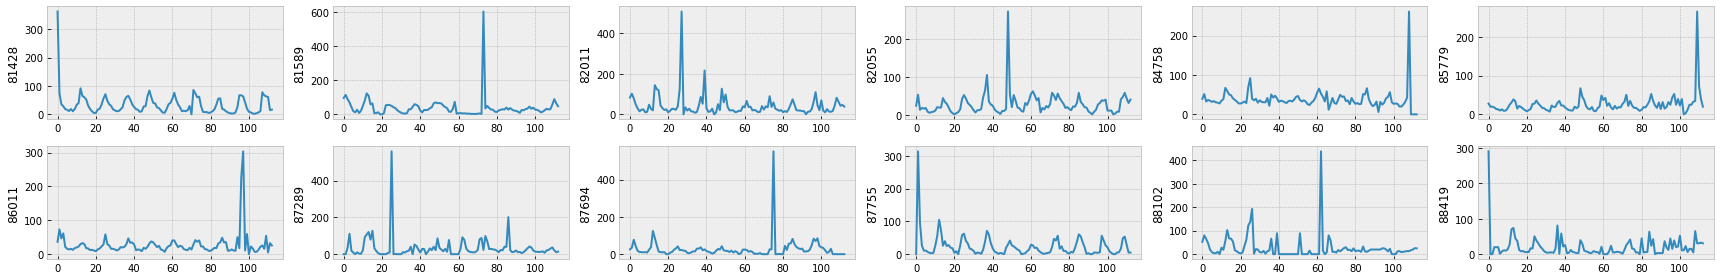

In [ ]:
ncols, nrows = 6, 2
size = (4, 2)
fig, axes = plt.subplots(nrows, ncols, figsize = (ncols * size[0], nrows * size[1]))
temp = test.loc[sp.stats.kurtosis(test, axis = 1) > 40]
print(temp.shape[0])
for r in range(nrows):
    for c in range(ncols):
        idx = c + ncols * r
        if idx >= temp.shape[0]: break
        sns.lineplot(x = range(temp.columns.size), y = temp.iloc[idx], ax = axes[r, c])
plt.tight_layout()

In [ ]:
sp.stats.kurtosis(test, axis = 1).mean() + 6 * sp.stats.kurtosis(test, axis = 1).std()

28.294815926273362

In [ ]:
sp.stats.skew(test, axis = 1).mean() + 6 * sp.stats.skew(test, axis = 1).std()

5.6034209621817785

In [ ]:
train_clean2.apply(sp.stats.kurtosis, axis = 1).describe(percentiles = [0.5, 0.95, 0.997])

count    62770.000000
mean         2.411066
std          5.124423
min         -1.608116
50%          0.920688
95%         10.461074
99.7%       37.711130
max        113.700441
dtype: float64

In [ ]:
train_clean2.apply(sp.stats.skew, axis = 1).describe(percentiles = [0.5, 0.95, 0.997])

count    62770.000000
mean         1.393809
std          0.798004
min         -1.903841
50%          1.229355
95%          2.854520
99.7%        5.443956
max         10.638171
dtype: float64

13


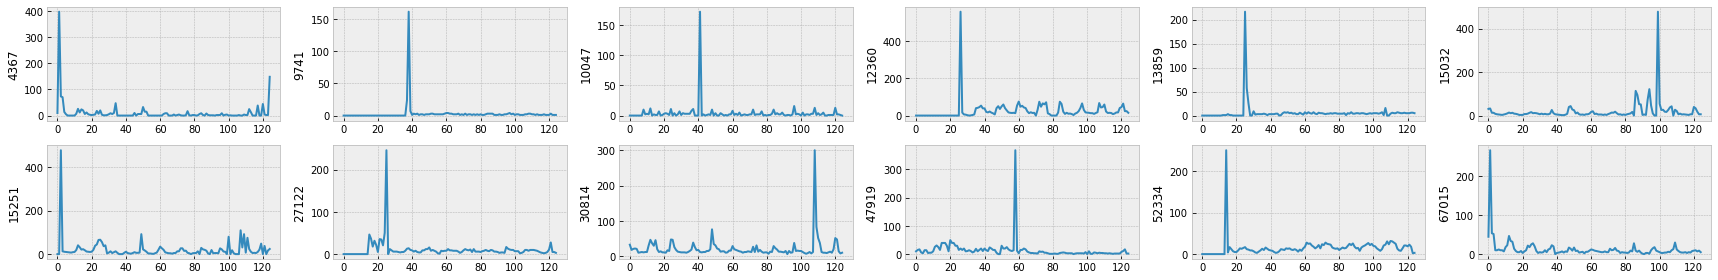

In [ ]:
ncols, nrows = 6, 2
size = (4, 2)
fig, axes = plt.subplots(nrows, ncols, figsize = (ncols * size[0], nrows * size[1]))
temp = train_clean2.loc[sp.stats.kurtosis(train_clean2, axis = 1) > 74]
print(temp.shape[0])
for r in range(nrows):
    for c in range(ncols):
        idx = c + ncols * r
        if idx >= temp.shape[0]: break
        sns.lineplot(x = range(temp.columns.size), y = temp.iloc[idx], ax = axes[r, c])
plt.tight_layout()

- temporal shock를 가진 데이터를 조금이나마 제거했습니다.
- test set에도 temporal shock가 관찰되기에 너무 많은 제거에는 조심스러웠습니다.

In [ ]:
train_clean3 = train_clean2[sp.stats.kurtosis(train_clean2, axis = 1) <= 74]
print(train_clean3.shape)
train_clean3.head()

(62757, 125)


2009-01  2009-02  2009-03  2009-04  2009-05  2009-06  2009-07  2009-08  \
id                                                                           
0     26.68    11.86    19.77    14.83     7.90     2.96     5.93     4.94   
1    107.73    77.09    79.09     4.94    48.44    22.74    33.61    23.72   
2     94.88    90.93    78.10    66.24    38.55    25.70    27.68    26.69   
3      0.00     0.00   149.29    51.41     6.92     8.89     2.96     2.96   
4     97.85    97.85    70.19    60.31    31.63    25.70    20.76    22.74   

    2009-09  2009-10  ...  2018-08  2018-09  2018-10  2018-11  2018-12  \
id                    ...                                                
0      4.94     4.94  ...     1.97     0.98     2.96     4.94     6.91   
1     23.72    25.70  ...    11.85    11.85    19.76    22.73    38.54   
2     18.78    15.81  ...     0.00     0.00     0.00     0.00    81.04   
3      1.97     3.95  ...     0.00     0.00     5.92    26.68    74.12   
4     20.76    20.76  ...     8.89     8.89    16.80    22.73    20.75   

    2019-01  2019-02  2019-03  2019-04  2019-05  
id                                               
0      9.88     0.00     2.96     7.90     4.94  
1    145.28    56.33    62.26    58.31    32.61  
2    130.45    71.15     0.00     0.00     0.00  
3    158.12   159.11   105.75    86.97    43.48  
4     26.68    32.61    19.76    21.74    15.81  

[5 rows x 125 columns]

### 4.4 Duplications

- 불량데이터에서 일정한 값을 가지는 유형을 제거하려고합니다.
- 시각화를 통해 이러한 데이터들은 이상한 추세를 보임을 알 수 있었습니다.
- duples는 0이 아닌 반복되는 수치들의 개수입니다.
- m_duples는 연속되어 나타나는 수치들의 개수입니다.
- c_duples는 가장 많이 연속되어 나타나는 수치의 개수입니다.

- count_duple는 같은 값이 연속적으로 발견되는 가장 긴 구간의 길이입니다.
- 오래걸리기 때문에 데이터값을 저장해서 사용했습니다.

In [ ]:
def count_duple(row):
    count, max_count = 0, 0
    for i in range(row.size):
        if i == 0:
            prev = row[i]
            continue
        if row[i] == 0:
            count = 0
            continue
        if prev == row[i]: count += 1
        else: count = 0
        prev = row[i]
        if max_count < count: max_count = count
    return max_count

In [ ]:
test_duple_info = test.assign(
    duples = lambda x: np.sum(x.apply(lambda x: pd.Series.duplicated(x) & (x != 0), axis = 1), axis = 1), # just duples
    m_duples = lambda x:x.diff(1, axis = 1).isin([0]).sum(axis = 1),
    c_duples = lambda x: x.apply(count_duple, axis = 1)
).filter(items = ['duples', 'm_duples', 'c_duples'])
test_duple_info.to_csv('data/test_duple_info.csv')
test_duple_info = pd.read_csv('data/test_duple_info.csv', index_col = 'id')

In [ ]:
test_duple_info.describe(percentiles = [0.5, 0.68, 0.95, 0.997])

duples      m_duples      c_duples
count  10000.000000  10000.000000  10000.000000
mean      29.318100      7.514300      1.448600
std       10.380505      5.839264      0.923062
min        5.000000      0.000000      0.000000
50%       28.000000      6.000000      1.000000
68%       33.000000      8.000000      2.000000
95%       48.000000     19.000000      3.000000
99.7%     61.003000     35.000000      7.000000
max       89.000000     66.000000     31.000000

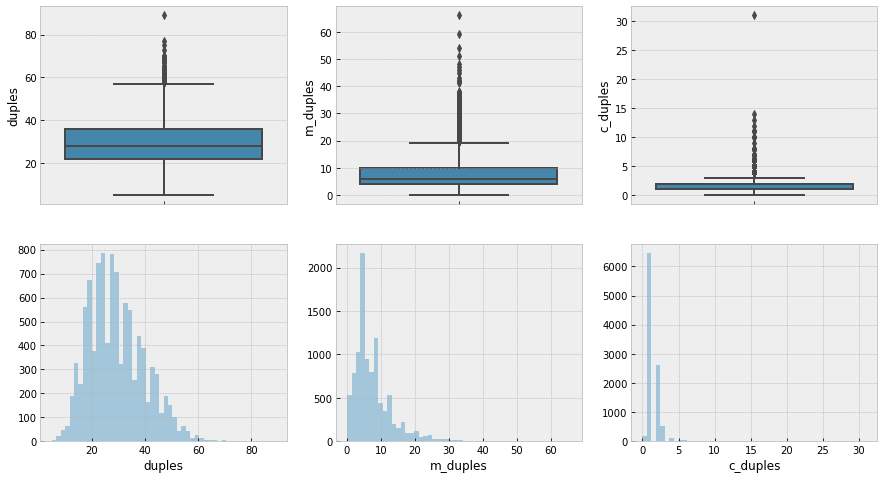

In [ ]:
fig, axes = plt.subplots(ncols = 3, nrows = 2, figsize = (15, 8))
sns.boxplot(y = 'duples', data = test_duple_info, ax = axes[0, 0])
sns.distplot(test_duple_info.duples, kde = False, ax = axes[1, 0])
sns.boxplot(y = 'm_duples', data = test_duple_info, ax = axes[0, 1])
sns.distplot(test_duple_info.m_duples, kde = False, ax = axes[1, 1])
sns.boxplot(y = 'c_duples', data = test_duple_info, ax = axes[0, 2])
sns.distplot(test_duple_info.c_duples, kde = False, ax = axes[1, 2])
plt.show()

In [ ]:
test_duple_info.\
agg(lambda x: np.mean(x) + 6*np.std(x)).to_frame().rename(columns = {0: '6 sigma'})

6 sigma
duples    91.598017
m_duples  42.548133
c_duples   6.986694

16


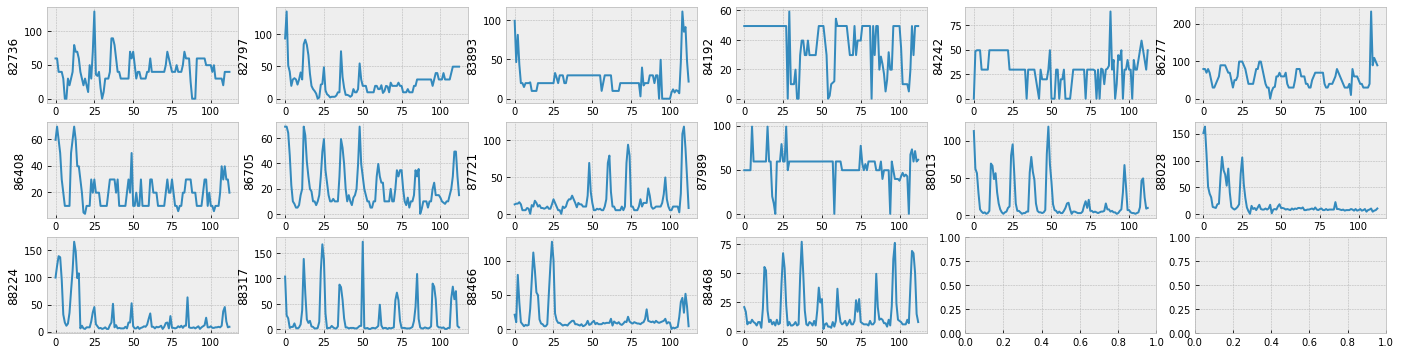

In [ ]:
ncols, nrows = 6, 3
size = (4, 2)
fig, axes = plt.subplots(nrows, ncols, figsize = (ncols * size[0], nrows * size[1]))
temp = test.loc[test_duple_info.query('duples > 64').index]
print(temp.shape[0])
for r in range(nrows):
    for c in range(ncols):
        idx = c + ncols * r
        if idx >= temp.shape[0]: break
        sns.lineplot(x = range(temp.columns.size), y = temp.iloc[idx], ax = axes[r, c])

In [ ]:
train_duple_info = train.assign(
    x_duples = lambda x: np.sum(x.loc[:, :'2018-05'].apply(lambda x: pd.Series.duplicated(x) & x != 0, axis = 1), axis = 1),
    y_duples = lambda x: np.sum(x.loc[:, '2018-06':].apply(lambda x: pd.Series.duplicated(x) & x != 0, axis = 1), axis = 1),
    m_duples = lambda x:x.diff(1, axis = 1).isin([0]).sum(axis = 1),
    c_duples = lambda x: x.apply(count_duple, axis = 1)
).filter(items = ['m_duples', 'x_duples', 'y_duples', 'c_duples'])
train_duple_info.to_csv('data/train_duple_info.csv')
train_duple_info = pd.read_csv('data/train_duple_info.csv', index_col = 'id')

In [ ]:
train_duple_info.describe(percentiles = [0.5, 0.68, 0.95, 0.997])

m_duples      x_duples      y_duples      c_duples
count  78587.000000  78587.000000  78587.000000  78587.000000
mean      11.261252     25.065851      1.148040      1.540916
std       14.998938     14.578304      1.535959      1.294541
min        0.000000      0.000000      0.000000      0.000000
50%        7.000000     22.000000      1.000000      1.000000
68%       10.000000     29.000000      1.000000      2.000000
95%       38.000000     54.000000      4.000000      3.000000
99.7%    109.000000     82.000000      9.000000     11.000000
max      120.000000    104.000000     11.000000     44.000000

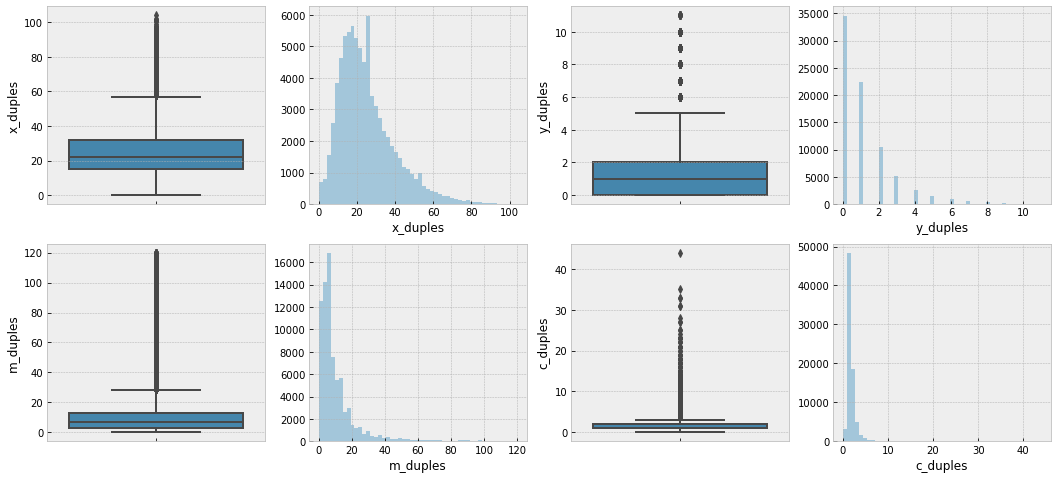

In [ ]:
fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize = (18, 8))
sns.boxplot(y = 'x_duples', data = train_duple_info, ax = axes[0, 0])
sns.distplot(train_duple_info.x_duples, kde = False, ax = axes[0, 1])
sns.boxplot(y = 'y_duples', data = train_duple_info, ax = axes[0, 2])
sns.distplot(train_duple_info.y_duples, kde = False, ax = axes[0, 3])
sns.boxplot(y = 'm_duples', data = train_duple_info, ax = axes[1, 0])
sns.distplot(train_duple_info.m_duples, kde = False, ax = axes[1, 1])
sns.boxplot(y = 'c_duples', data = train_duple_info, ax = axes[1, 2])
sns.distplot(train_duple_info.c_duples, kde = False, ax = axes[1, 3])
plt.show()

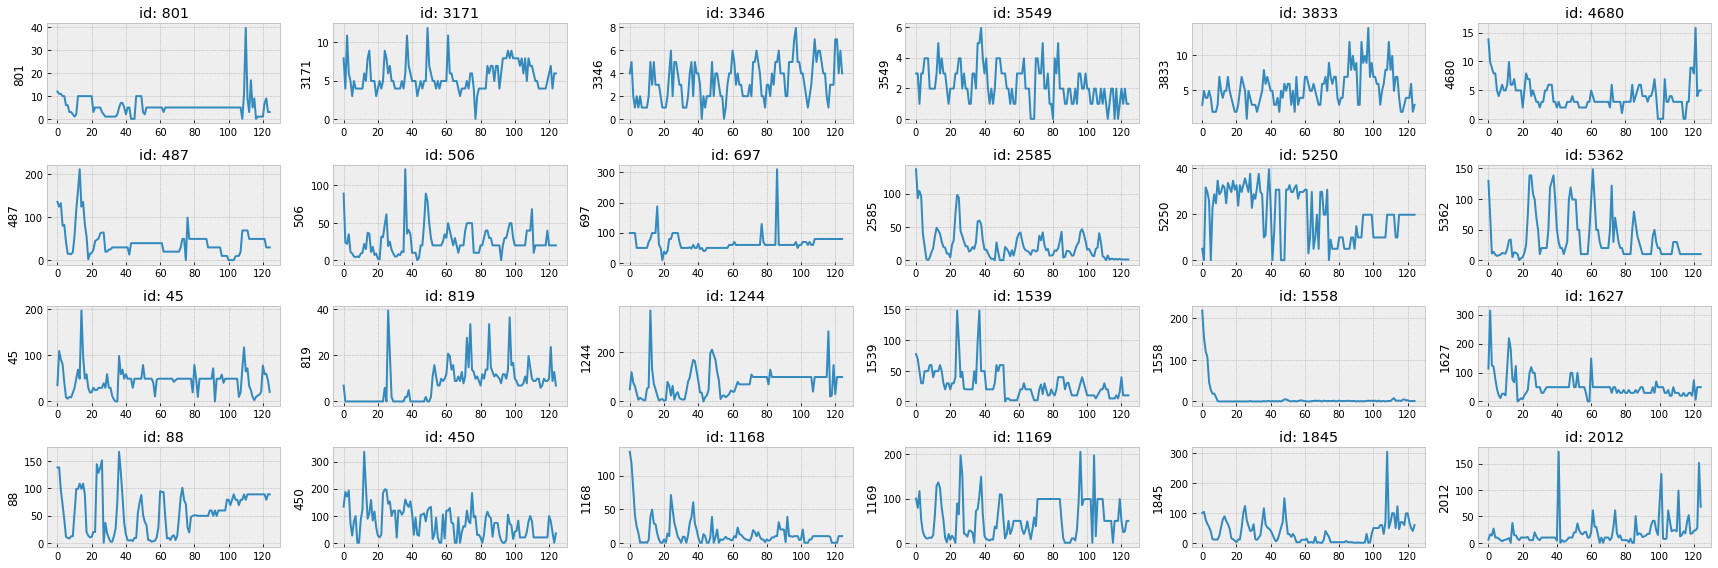

In [ ]:
ncols, nrows = 6, 4
size = (4, 2)
fig, axes = plt.subplots(nrows, ncols, figsize = (ncols * size[0], nrows * size[1]))

temp = train_clean3.loc[train_duple_info.query('x_duples > 91').index].dropna(axis = 0)
for i in range(ncols):
    sns.lineplot(x = range(temp.columns.size), y = temp.iloc[i], ax = axes[0, i])
    axes[0, i].set_title(f'id: {temp.index[i]}')

temp = train_clean3.loc[train_duple_info.query('x_duples <= 91 & y_duples > 9').index].dropna(axis = 0)
for i in range(ncols):
    sns.lineplot(x = range(temp.columns.size), y = temp.iloc[i], ax = axes[1, i])
    axes[1, i].set_title(f'id: {temp.index[i]}')

temp = train_clean3.loc[train_duple_info.query('x_duples <= 91 & y_duples <= 9 & m_duples > 42').index].dropna(axis = 0)
for i in range(ncols):
    sns.lineplot(x = range(temp.columns.size), y = temp.iloc[i], ax = axes[2, i])
    axes[2, i].set_title(f'id: {temp.index[i]}')

temp = train_clean3.loc[train_duple_info.query('x_duples <= 91 & y_duples <= 9 & m_duples <= 42 & c_duples > 7').index].dropna(axis = 0)
for i in range(ncols):
    if i >= temp.shape[0]: break
    sns.lineplot(x = range(temp.columns.size), y = temp.iloc[i], ax = axes[3, i])
    axes[3, i].set_title(f'id: {temp.index[i]}')

plt.tight_layout()

- 3천개 정도의 관측치가 제거되었습니다.
- 가장 효과가 좋았던 정제 방법으로 생각됩니다.
- 좀 더 과감하게 삭제했다면 더 좋은 성적을 얻었을거라 생각됩니다.

In [ ]:
train_clean4 = train_clean3.\
    loc[train_duple_info.query('x_duples <= 91 & y_duples <= 9 & m_duples <= 42 & c_duples <= 7').index].\
    dropna(axis = 0)
print(train_clean4.shape[0])
train_clean4.head()

62193


2009-01  2009-02  2009-03  2009-04  2009-05  2009-06  2009-07  2009-08  \
id                                                                           
0     26.68    11.86    19.77    14.83     7.90     2.96     5.93     4.94   
1    107.73    77.09    79.09     4.94    48.44    22.74    33.61    23.72   
2     94.88    90.93    78.10    66.24    38.55    25.70    27.68    26.69   
3      0.00     0.00   149.29    51.41     6.92     8.89     2.96     2.96   
4     97.85    97.85    70.19    60.31    31.63    25.70    20.76    22.74   

    2009-09  2009-10  ...  2018-08  2018-09  2018-10  2018-11  2018-12  \
id                    ...                                                
0      4.94     4.94  ...     1.97     0.98     2.96     4.94     6.91   
1     23.72    25.70  ...    11.85    11.85    19.76    22.73    38.54   
2     18.78    15.81  ...     0.00     0.00     0.00     0.00    81.04   
3      1.97     3.95  ...     0.00     0.00     5.92    26.68    74.12   
4     20.76    20.76  ...     8.89     8.89    16.80    22.73    20.75   

    2019-01  2019-02  2019-03  2019-04  2019-05  
id                                               
0      9.88     0.00     2.96     7.90     4.94  
1    145.28    56.33    62.26    58.31    32.61  
2    130.45    71.15     0.00     0.00     0.00  
3    158.12   159.11   105.75    86.97    43.48  
4     26.68    32.61    19.76    21.74    15.81  

[5 rows x 125 columns]

### 4.5 Anormal values

- 어느정도 사용량이 있다가 갑자기 이상한 추세를 보이는 경우를 제거하려고 합니다.
- target variable 근처에서 사용량이 거의 없는 데이터를 제거하는 것이 목적입니다.

In [ ]:
X_train = train.iloc[:, :-12]
y_train = train.iloc[:, -12:]

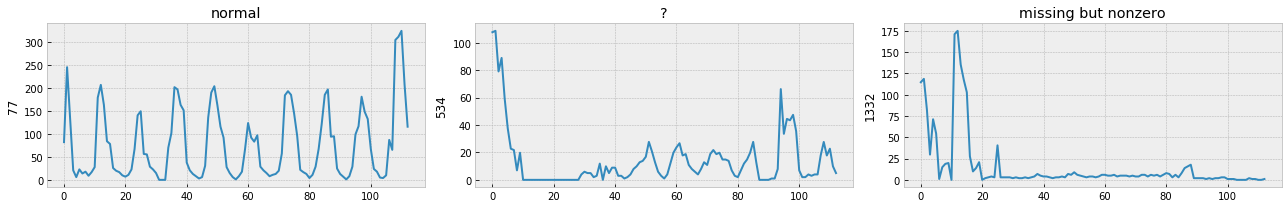

In [ ]:
fig, axes = plt.subplots(ncols = 3, figsize = (18, 3))

sns.lineplot(x = range(X_train.columns.size), y = X_train.loc[77], ax = axes[0])
axes[0].set_title('normal')
sns.lineplot(x = range(X_train.columns.size), y = X_train.loc[534], ax = axes[1])
axes[1].set_title('?')
sns.lineplot(x = range(X_train.columns.size), y = X_train.loc[1332], ax = axes[2])
axes[2].set_title('missing but nonzero')

plt.tight_layout()

- 사용<u>시기</u>가 예측이 안되는 경우를 골라내어 제거하는 것이 목표입니다.
- min-max scaling을 통해 0 ~ 1 사이의 값으로 맞춘 후, 비교적 큰 수요에 대한 feature 개수를 계산합니다.
- 이 방법은 이상치에 민감하기 때문에 먼저 데이터를 절삭(trim)한 후 적용하였습니다.

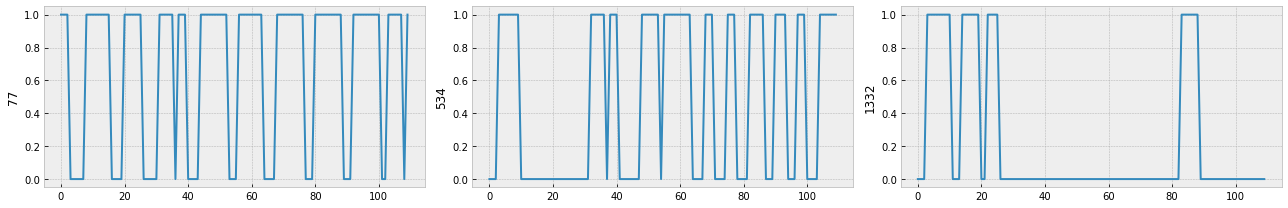

In [ ]:
scaler = MinMaxScaler()

trim, cut = 90, 0.2
fig, axes = plt.subplots(ncols = 3, figsize = (18, 3))
temp = X_train.copy()
temp = temp.clip(0, np.percentile(temp, trim, axis = 1), axis = 0)
temp = temp.diff(periods = 1, axis = 1).dropna(axis = 1).abs()

temp_df = pd.DataFrame(scaler.fit(temp.T).transform(temp.T).T)
temp_df.index, temp_df.columns = temp.index, temp.columns
temp_df = temp_df.apply(lambda x: x >= cut).astype(int)
temp_df = temp_df.rolling(window = 3, axis = 1, center = True).max().dropna(axis = 1)

sns.lineplot(x = range(temp_df.columns.size), y = temp_df.loc[77], ax = axes[0])
sns.lineplot(x = range(temp_df.columns.size), y = temp_df.loc[534], ax = axes[1])
sns.lineplot(x = range(temp_df.columns.size), y = temp_df.loc[1332], ax = axes[2])

plt.tight_layout()

In [ ]:
temp_df.loc[[77, 534, 1332]].apply([np.mean], axis = 1)

mean
77    0.681818
534   0.490909
1332  0.218182

In [ ]:
def find_anormal(df, trim, cut):
    scaler = MinMaxScaler()

    temp = df.clip(0, np.percentile(df, trim, axis = 1), axis = 0)
    temp = temp.diff(periods = 1, axis = 1).dropna(axis = 1).abs()

    temp_df = pd.DataFrame(scaler.fit(temp.T).transform(temp.T).T)
    temp_df.index, temp_df.columns = temp.index, temp.columns
    temp_df = temp_df.apply(lambda x: x >= cut).astype(int)
    temp_df = temp_df.rolling(window = 3, axis = 1, center = True).max().dropna(axis = 1)
    return temp_df

19


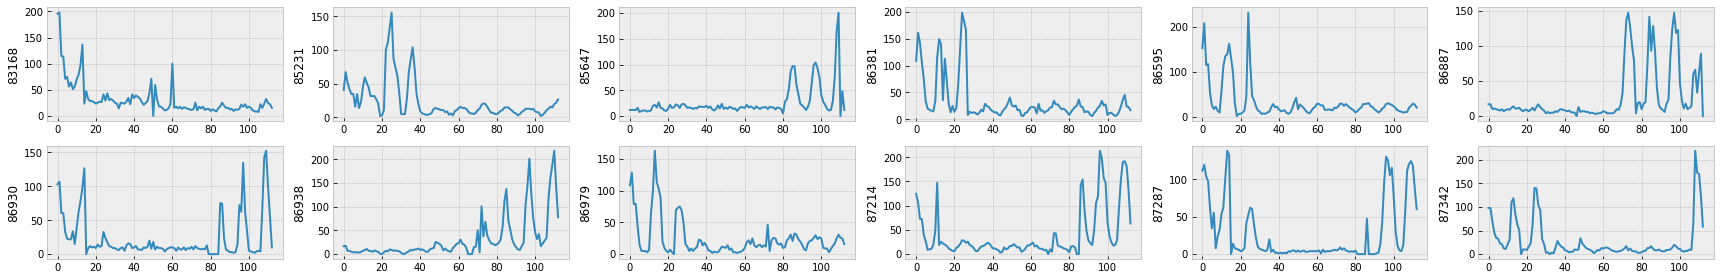

In [ ]:
ncols, nrows = 6, 2
size = (4, 2)
temp_df = test[find_anormal(test, 90, .2).mean(axis = 1) < .3]
print(temp_df.shape[0])

fig, axes = plt.subplots(nrows, ncols, figsize = (ncols * size[0], nrows * size[1]))
for r in range(nrows):
    for c in range(ncols):
        idx = c + ncols * r
        if idx >= temp_df.shape[0]: break
        sns.lineplot(x = range(temp_df.columns.size), y = temp_df.iloc[idx], ax = axes[r, c])
plt.tight_layout()

267


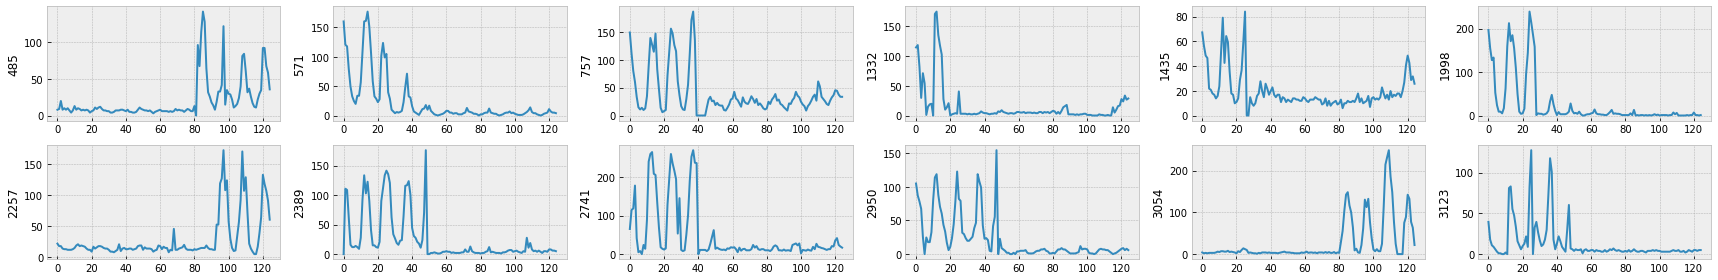

In [ ]:
ncols, nrows = 6, 2
size = (4, 2)
temp_df = train_clean4[find_anormal(train_clean4, 90, .2).mean(axis = 1) < .3]
print(temp_df.shape[0])

fig, axes = plt.subplots(nrows, ncols, figsize = (ncols * size[0], nrows * size[1]))
for r in range(nrows):
    for c in range(ncols):
        idx = c + ncols * r
        if idx >= temp_df.shape[0]: break
        sns.lineplot(x = range(temp_df.columns.size), y = temp_df.iloc[idx], ax = axes[r, c])
plt.tight_layout()

- 이번에는 사용<u>량</u>이 예측이 안되는 경우를 골라내어 제거하는 것이 목표입니다.
- autocorrelation을 이용하여 계절성이 눈에 띄지 않는 경우를 감지합니다.
- lag = 12로 설정하여 yearly seasonality를 정량화 합니다.

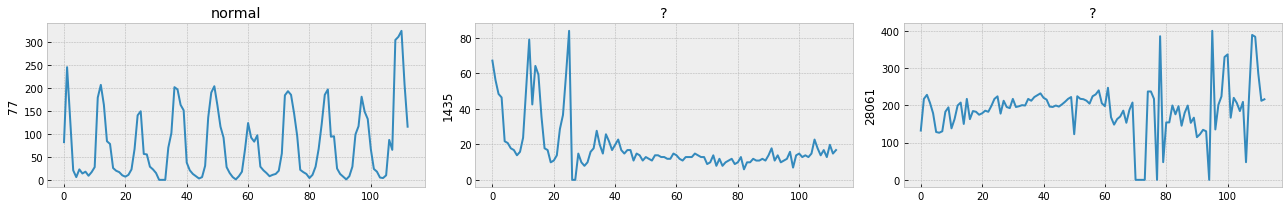

In [ ]:
fig, axes = plt.subplots(ncols = 3, figsize = (18, 3))

sns.lineplot(x = range(X_train.columns.size), y = X_train.loc[77], ax = axes[0])
axes[0].set_title('normal')
sns.lineplot(x = range(X_train.columns.size), y = X_train.loc[1435], ax = axes[1])
axes[1].set_title('?')
sns.lineplot(x = range(X_train.columns.size), y = X_train.loc[28061], ax = axes[2])
axes[2].set_title('?')

plt.tight_layout()

In [ ]:
test.apply(lambda x: x.autocorr(lag = 12), axis = 1).describe([0.1, 0.05, 0.01, 0.001])

count    10000.000000
mean         0.661646
std          0.168783
min         -0.320011
0.1%         0.019301
1%           0.171389
5%           0.342255
10%          0.426069
50%          0.691555
max          0.965309
dtype: float64

In [ ]:
train.loc[[77, 1435, 28061]].apply(lambda x: x.autocorr(lag = 12), axis = 1)

id
77       0.743971
1435     0.508908
28061    0.016554
dtype: float64

274


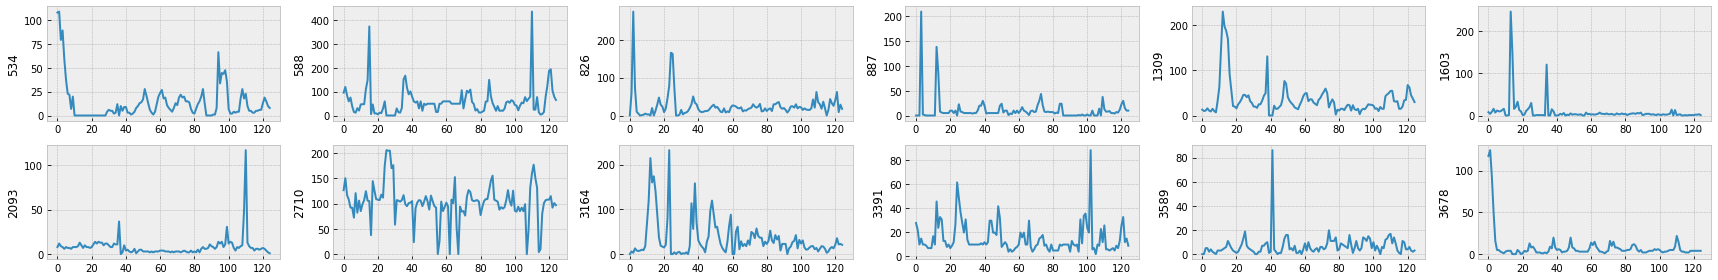

In [ ]:
ncols, nrows = 6, 2
size = (4, 2)
temp_df = train_clean4[train_clean4.apply(lambda x: x.autocorr(lag = 12), axis = 1) < 0.1]
print(temp_df.shape[0])

fig, axes = plt.subplots(nrows, ncols, figsize = (ncols * size[0], nrows * size[1]))
for r in range(nrows):
    for c in range(ncols):
        idx = c + ncols * r
        if idx >= temp_df.shape[0]: break
        sns.lineplot(x = range(temp_df.columns.size), y = temp_df.iloc[idx], ax = axes[r, c])
plt.tight_layout()

In [ ]:
train_clean5 = train_clean4[
    (find_anormal(train_clean4, 90, .2).mean(axis = 1) > .3) &
    (train_clean4.apply(lambda x: x.autocorr(lag = 12), axis = 1) > 0.1)
]
print(train_clean5.shape)
train_clean5.head()

(61656, 125)


2009-01  2009-02  2009-03  2009-04  2009-05  2009-06  2009-07  2009-08  \
id                                                                           
0     26.68    11.86    19.77    14.83     7.90     2.96     5.93     4.94   
1    107.73    77.09    79.09     4.94    48.44    22.74    33.61    23.72   
2     94.88    90.93    78.10    66.24    38.55    25.70    27.68    26.69   
3      0.00     0.00   149.29    51.41     6.92     8.89     2.96     2.96   
4     97.85    97.85    70.19    60.31    31.63    25.70    20.76    22.74   

    2009-09  2009-10  ...  2018-08  2018-09  2018-10  2018-11  2018-12  \
id                    ...                                                
0      4.94     4.94  ...     1.97     0.98     2.96     4.94     6.91   
1     23.72    25.70  ...    11.85    11.85    19.76    22.73    38.54   
2     18.78    15.81  ...     0.00     0.00     0.00     0.00    81.04   
3      1.97     3.95  ...     0.00     0.00     5.92    26.68    74.12   
4     20.76    20.76  ...     8.89     8.89    16.80    22.73    20.75   

    2019-01  2019-02  2019-03  2019-04  2019-05  
id                                               
0      9.88     0.00     2.96     7.90     4.94  
1    145.28    56.33    62.26    58.31    32.61  
2    130.45    71.15     0.00     0.00     0.00  
3    158.12   159.11   105.75    86.97    43.48  
4     26.68    32.61    19.76    21.74    15.81  

[5 rows x 125 columns]

### 4.6 Out of cluster

- 제가 실험적으로 시도해보고 있는 전처리방법입니다.
- DBSCAN(Density-Based Spatial Clustering of Applications with Noise)을 사용하여 학습에 용이하지 않은 데이터를 제거합니다.
- clustering 과정에서 feature의 개수가 너무 많아 PCA를 이용해 주성분을 추출하였습니다.
- 간단한 EDA 및 시각화를 위해 차원을 2까지 축소했습니다만 optimal한 차원을 찾는 것을 추천합니다.
- 참고로 PCA전에 반드시 scaling을 해줍니다 (분산을 같게 해주어야 함).
- DBSCAN의 parameter인 epsilon에 대해서 train set과 test set 모두 같을 필요는 없습니다.
- 4.1~4.5의 전처리가 잘 될수록 이 방법으로 제거되는 데이터 수가 적어졌습니다.

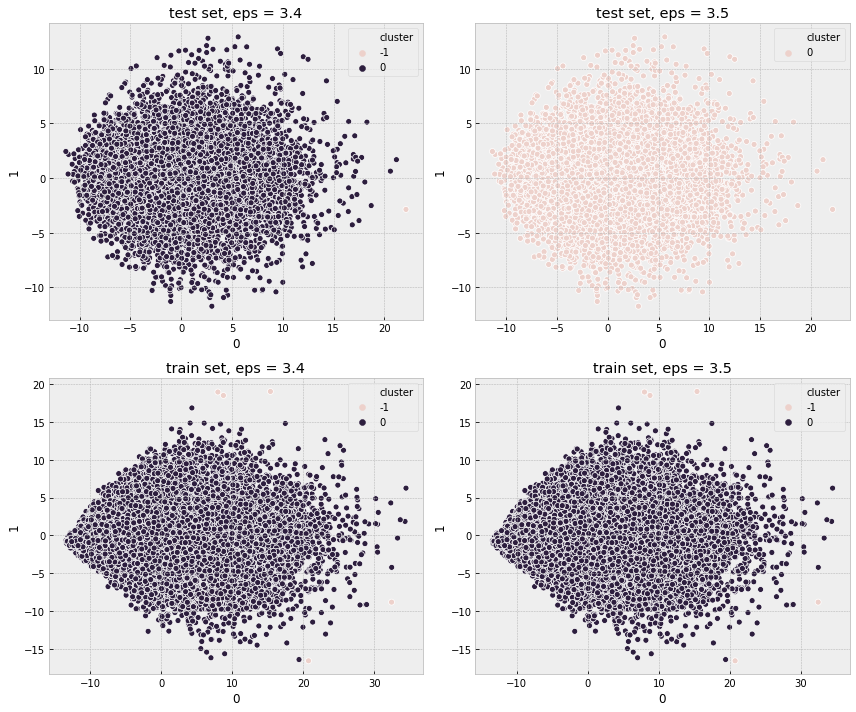

In [ ]:
def show_CLUSTER(df, eps, ax):
    temp_df = df.copy()
    scaler = StandardScaler()
    scaler.fit(temp_df)
    scaled_df = scaler.transform(temp_df)
    
    model_PCA = PCA(2)
    model_PCA.fit(scaled_df)
    result_PCA = model_PCA.transform(scaled_df)
    reduced_df = pd.DataFrame(result_PCA)

    model_DBSCAN = DBSCAN(eps = eps)
    model_DBSCAN.fit(reduced_df)
    reduced_df['cluster'] = model_DBSCAN.labels_
  
    return sns.scatterplot(x = 0, y = 1, data = reduced_df, hue = 'cluster', ax = ax)

fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 10))
eps = 3.4

show_CLUSTER(test, eps = eps, ax = axes[0, 0])
axes[0, 0].set_title(f'test set, eps = {eps}')

show_CLUSTER(test, eps = eps + .1, ax = axes[0, 1])
axes[0, 1].set_title(f'test set, eps = {eps + .1}')

show_CLUSTER(train_clean5.iloc[:, :-12], eps = eps, ax = axes[1, 0])
axes[1, 0].set_title(f'train set, eps = {eps}')

show_CLUSTER(train_clean5.iloc[:, :-12], eps = eps + .1, ax = axes[1, 1])
axes[1, 1].set_title(f'train set, eps = {eps + .1}')

plt.tight_layout()

In [ ]:
temp_df = train_clean5.iloc[:, :-12]
scaler = StandardScaler()
scaler.fit(temp_df)
scaled_df = scaler.transform(temp_df)

model_PCA = PCA(2)
model_PCA.fit(scaled_df)
result_PCA = model_PCA.transform(scaled_df)
reduced_df = pd.DataFrame(result_PCA)

model_DBSCAN = DBSCAN(eps = 3.4)
model_DBSCAN.fit(reduced_df)
reduced_df['cluster'] = model_DBSCAN.labels_

5


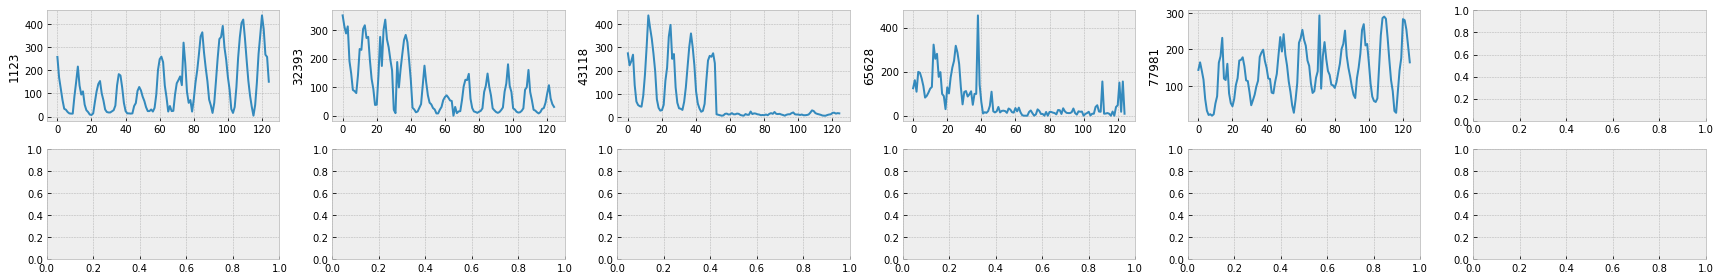

In [ ]:
temp = train_clean5[(reduced_df.cluster != 0).values]
print(temp.shape[0])

ncols, nrows = 6, 2
size = (4, 2)
fig, axes = plt.subplots(nrows, ncols, figsize = (ncols * size[0], nrows * size[1]))

for r in range(nrows):
    for c in range(ncols):
        idx = c + ncols * r
        if idx >= temp.shape[0]: break
        sns.lineplot(x = range(temp.columns.size), y = temp.iloc[idx], ax = axes[r, c])

plt.tight_layout()

In [ ]:
train_final = train_clean5[(reduced_df.cluster == 0).values]
print(train_final.shape)
train_final.head()

(61651, 125)


2009-01  2009-02  2009-03  2009-04  2009-05  2009-06  2009-07  2009-08  \
id                                                                           
0     26.68    11.86    19.77    14.83     7.90     2.96     5.93     4.94   
1    107.73    77.09    79.09     4.94    48.44    22.74    33.61    23.72   
2     94.88    90.93    78.10    66.24    38.55    25.70    27.68    26.69   
3      0.00     0.00   149.29    51.41     6.92     8.89     2.96     2.96   
4     97.85    97.85    70.19    60.31    31.63    25.70    20.76    22.74   

    2009-09  2009-10  ...  2018-08  2018-09  2018-10  2018-11  2018-12  \
id                    ...                                                
0      4.94     4.94  ...     1.97     0.98     2.96     4.94     6.91   
1     23.72    25.70  ...    11.85    11.85    19.76    22.73    38.54   
2     18.78    15.81  ...     0.00     0.00     0.00     0.00    81.04   
3      1.97     3.95  ...     0.00     0.00     5.92    26.68    74.12   
4     20.76    20.76  ...     8.89     8.89    16.80    22.73    20.75   

    2019-01  2019-02  2019-03  2019-04  2019-05  
id                                               
0      9.88     0.00     2.96     7.90     4.94  
1    145.28    56.33    62.26    58.31    32.61  
2    130.45    71.15     0.00     0.00     0.00  
3    158.12   159.11   105.75    86.97    43.48  
4     26.68    32.61    19.76    21.74    15.81  

[5 rows x 125 columns]

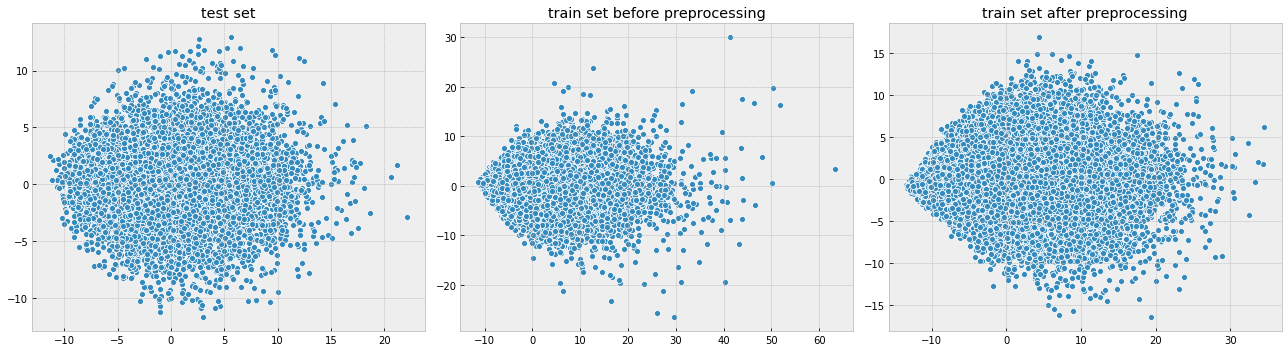

In [ ]:
def show_PCA(df, ax):
    scaler = StandardScaler()
    scaler.fit(df)
    scaled_df = scaler.transform(df)
    
    model = PCA(2)
    model.fit(scaled_df)
    result = model.transform(scaled_df)
    return sns.scatterplot(x = result[:, 0], y = result[:, 1], ax = ax)

fig, axes = plt.subplots(ncols = 3, figsize = (18, 5))

show_PCA(test, ax = axes[0])
axes[0].set_title('test set')

show_PCA(train.iloc[:, :113], ax = axes[1])
axes[1].set_title('train set before preprocessing')

show_PCA(train_final.iloc[:, :113], ax = axes[2])
axes[2].set_title('train set after preprocessing')

plt.tight_layout()

## 5. Feature selection

- 그간의 시각화를 통해 눈치챘겠지만 우리의 데이터는 계절성(seasonality)를 갖고 있습니다.
- random forest를 이용해 feature importance를 살펴보면, 어떤 달(month)의 도시가스 수요는 전년 동월 및 바로 전월의 도시가스 수요와 관계가 높습니다.
- 2009년도 데이터는 예측하는데 딱히 영향을 주지 않는 것으로 판단됩니다.
- 추세(trend)가 눈에 띄지는 않습니다.

### 5.1 Seasonality

- 12개월 마다 반복되는 주기가 있습니다.

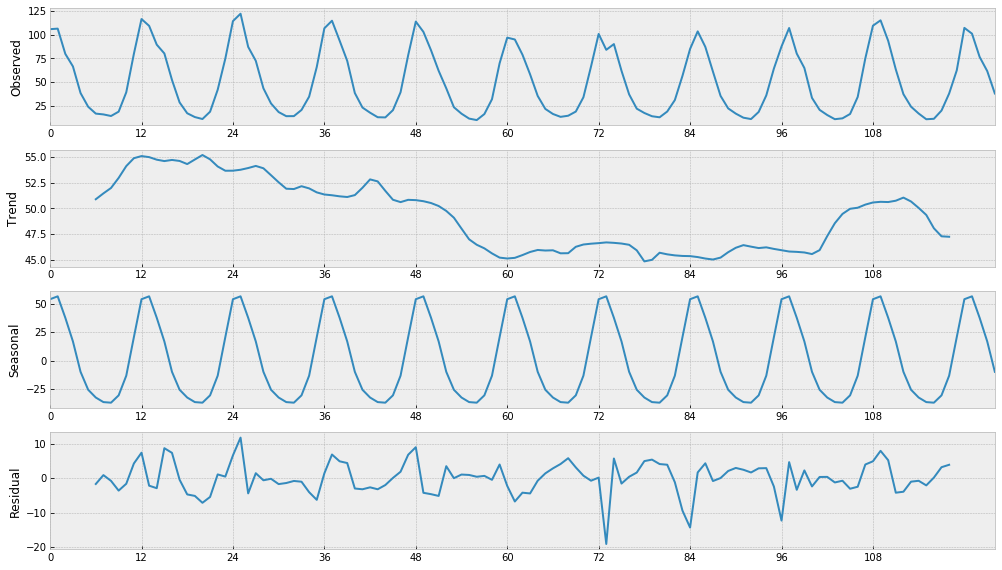

In [ ]:
sd = seasonal_decompose(train_final.mean(axis = 0).values, freq = 12)

fig, axes = plt.subplots(nrows = 4, figsize = (14, 8))

pd.Series(sd.observed).plot(ax=axes[0])
axes[0].set_ylabel('Observed')
axes[0].xaxis.set_ticks(np.arange(0, 120, step = 12))
pd.Series(sd.trend).plot(ax=axes[1])
axes[1].set_ylabel('Trend')
axes[1].xaxis.set_ticks(np.arange(0, 120, step = 12))
pd.Series(sd.seasonal).plot(ax=axes[2])
axes[2].set_ylabel('Seasonal')
axes[2].xaxis.set_ticks(np.arange(0, 120, step = 12))
pd.Series(sd.resid).plot(ax=axes[3])
axes[3].set_ylabel('Residual')
axes[3].xaxis.set_ticks(np.arange(0, 120, step = 12))
plt.tight_layout()

### 5.2 Autocorrelation

- 각각의 종속변수를 예측하는데 어떤 독립변수들이 가장 영향을 미치는지 알아보겠습니다.
- 첫번째로 autocorrelation을 계산해보면, 12의 배수 때 높은 값을 보입니다.
- 이는 가스 수요량이 연(year) 단위로 주기를 갖기 때문입니다.
- 기온이 낮은 겨울철에 수요량이 늘어나고, 보일러를 사용할 필요가 없는 여름철에 수요량이 줄어듦을 알 수 있습니다.

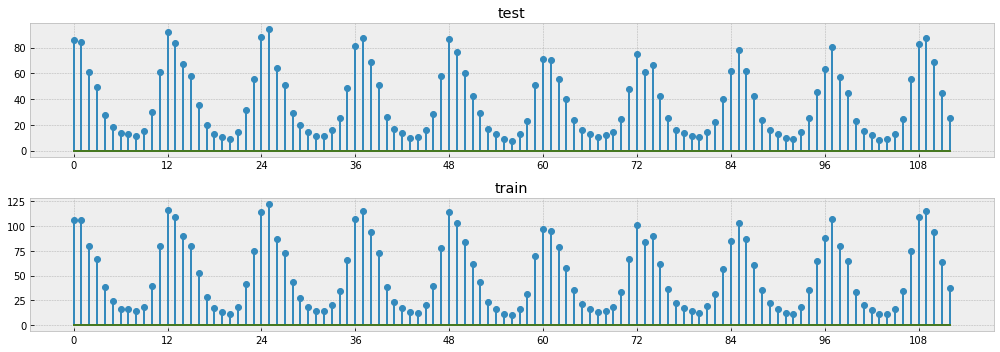

In [ ]:
test_mean = test.apply(np.mean, axis = 0)
train_mean = train_final.iloc[:, :-12].apply(np.mean, axis = 0)

fig, axes = plt.subplots(nrows = 2, figsize = (14, 5))
axes[0].stem(test_mean)
axes[0].set_title('test')
axes[0].xaxis.set_ticks(np.arange(0, 120, step = 12))
axes[1].stem(train_mean)
axes[1].set_title('train')
axes[1].xaxis.set_ticks(np.arange(0, 120, step = 12))
plt.tight_layout()

In [ ]:
autocorr_list = [(i, test_mean.autocorr(lag = i)) for i in range(test.columns.size - 1)]
feature_similarity = sorted(autocorr_list, key = lambda x: x[1], reverse = True)
display(feature_similarity[: 10])
display(feature_similarity[-1])

[(0, 1.0),
 (111, 1.0),
 (108, 0.9818867996016547),
 (96, 0.979514368067252),
 (12, 0.9774577618521801),
 (84, 0.9726203673145609),
 (60, 0.9725739861725826),
 (24, 0.9675657087883871),
 (72, 0.9656327307858353),
 (109, 0.965019956457454)]

(90, -0.8341513212241869)

In [ ]:
autocorr_list = [(i, train_mean.autocorr(lag = i)) for i in range(test.columns.size - 1)]
feature_similarity = sorted(autocorr_list, key = lambda x: x[1], reverse = True)
display(feature_similarity[: 10])
display(feature_similarity[-1])

[(0, 1.0),
 (96, 0.983798143642045),
 (108, 0.9837437976275335),
 (12, 0.980753394893531),
 (60, 0.9789496861491082),
 (84, 0.978619344787871),
 (72, 0.9728450437405711),
 (24, 0.972766862972719),
 (36, 0.9680020169929529),
 (48, 0.9662828571350075)]

(111, -1.0)

### 5.3 Correlation

- 전처리 이후 target month와 previous month 간의 상관관계 그래프를 그려보겠습니다.
- 여름철보다 겨울철에 선형성이 확실히 드러납니다.
- 7, 8월 수요량에서 100 근처의 값(98.84, 98.93으로 추정)이 인위적으로 느껴지지만 제거하지 못했습니다.

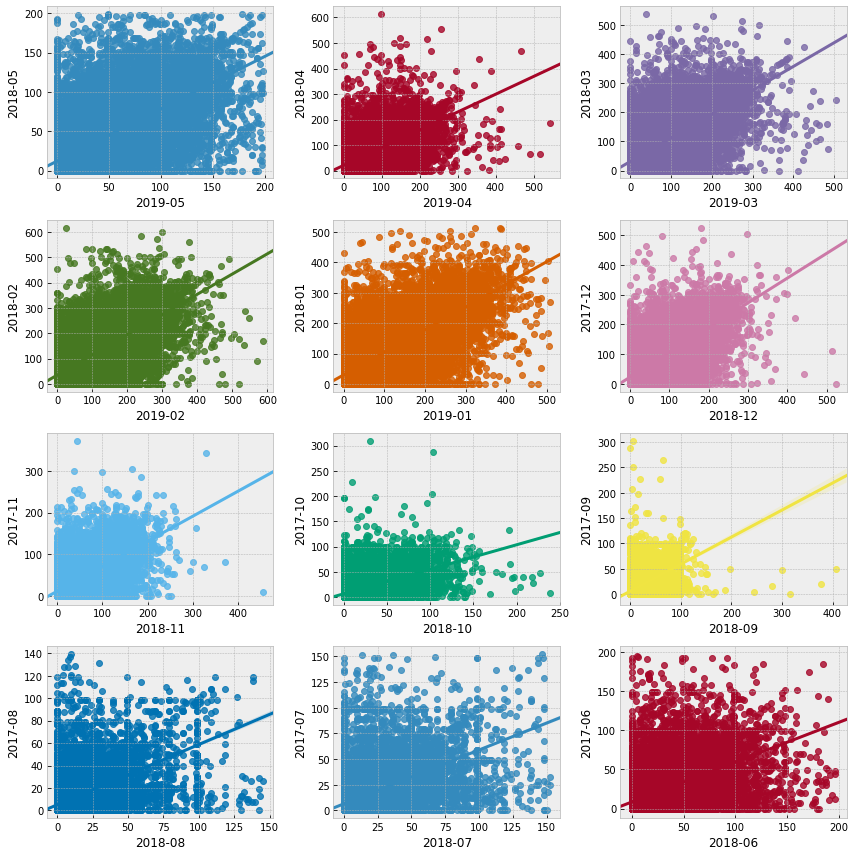

In [ ]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (12, 12))
for i in range(12):
    sns.regplot(x = f'{train_final.columns[-i-1]}', y = f'{train_final.columns[-i-13]}', data = train_final, ax = axes[divmod(i, 3)])
plt.tight_layout()

### 5.4 Feature importance

- random forest의 feature importance를 통해 정확히 어떤 달이 가장 영향을 미치는지 확인합니다.
- 이를 통해 전년 동월의 가스 수요량의 feature importance가 높음을 알 수 있었습니다.

In [ ]:
X = train_final.loc[:, '2009-01': '2018-05']
y = train_final.loc[:, '2018-06':]

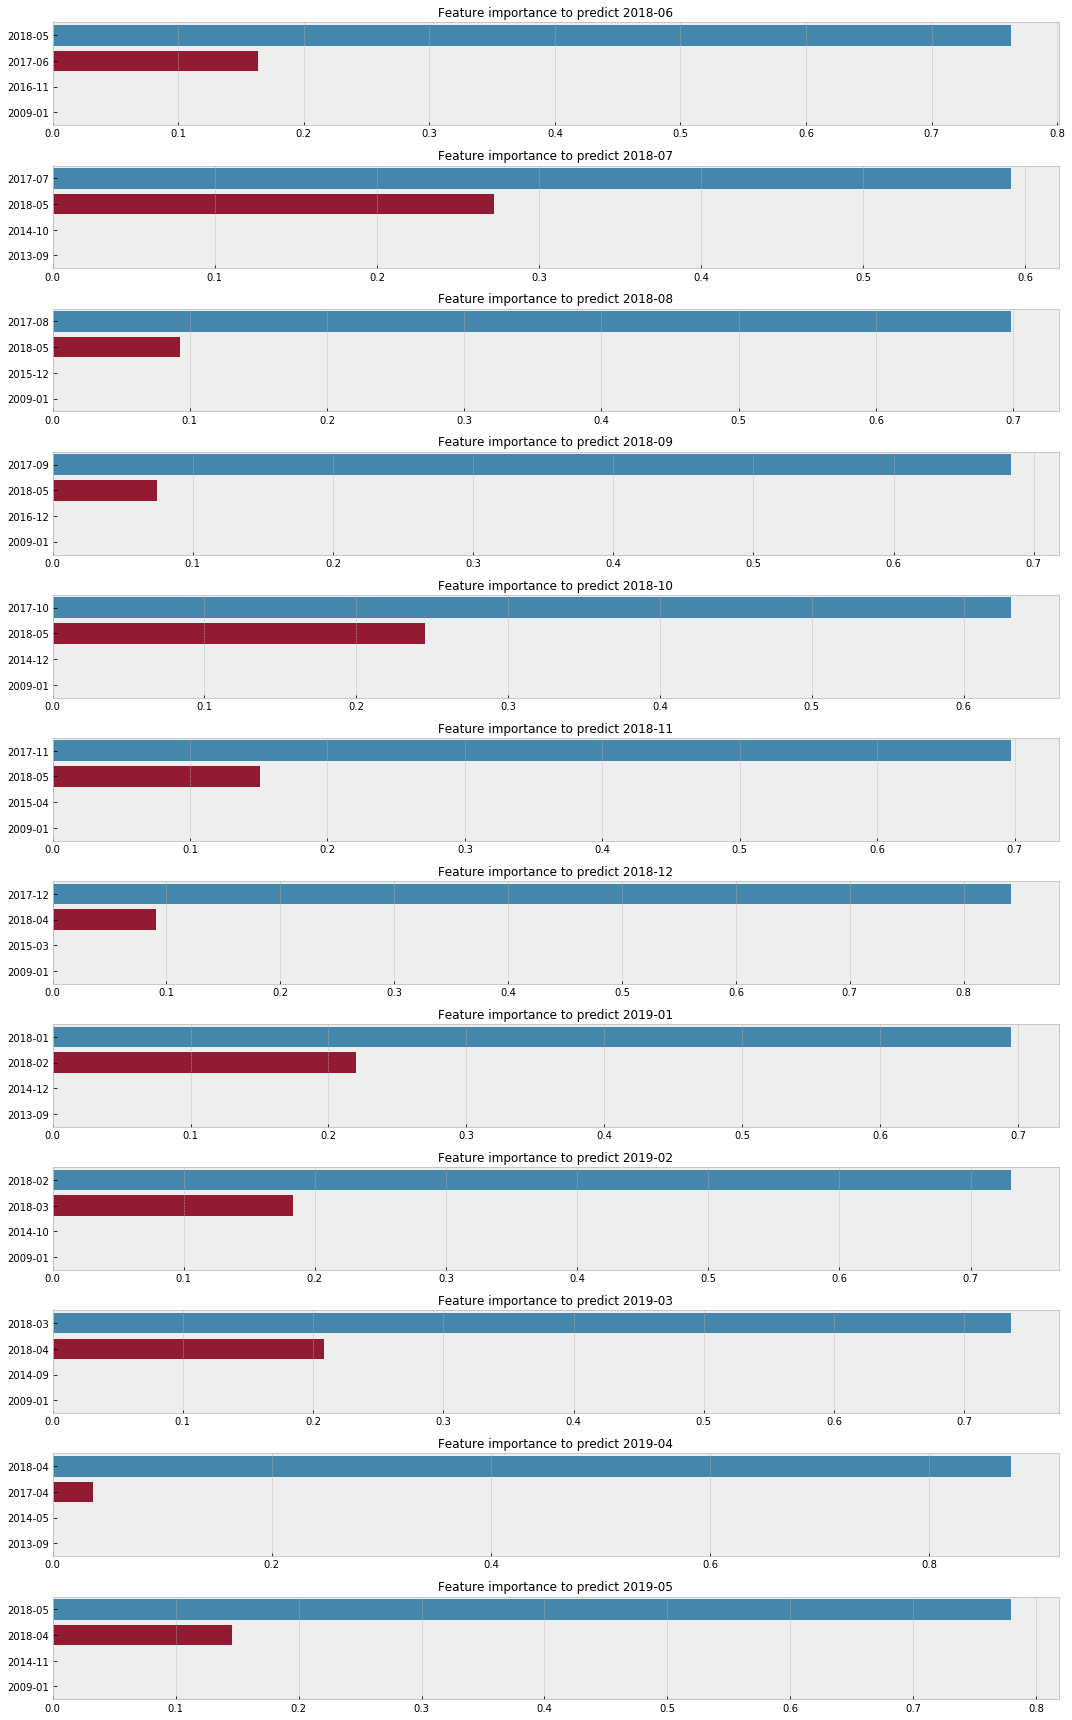

In [ ]:
fig, axes = plt.subplots(nrows = 12, figsize = (15, 24))
for i in range(12):
    model = RandomForestRegressor(n_estimators = 10, max_depth = 5, random_state = 777)
    model.fit(X, y.values[:, i])
    importances = model.feature_importances_
    importances_head = np.argsort(importances)[::-1][:2]
    importances_tail = np.argsort(importances)[::-1][-2:]
    importances_ = np.concatenate([importances_head, importances_tail])
    
    sns.barplot(x = importances[importances_], y = X.columns[importances_], ax = axes[i])
    axes[i].set_title(f'Feature importance to predict {y.columns[i]}', size = 12)
plt.tight_layout()

### 5.5 Trends by year

- 달(month)마다 어떻게 추세가 바뀌는지 확인합니다.

In [ ]:
temp_df = train_final.mean(axis = 0)

tab_list = list()
for i in range(10):
    p = figure(plot_width = 800, plot_height = 300)
    p.line(x = range(12), y = temp_df[12*i: 12*(i+1)], line_width = 2)
    p.xaxis.major_label_overrides = {i: f'{k+1:02d}' for i, k in enumerate(range(12))}
    p.xaxis[0].ticker.desired_num_ticks = 12

    tab = Panel(child = p, title = f'{2008 + i}')
    tab_list.append(tab)

tabs = Tabs(tabs = tab_list)
show(tabs)

### 5.6 Before preprocessing

- 전처리 전에는 최대최소값으로는 달(month)마다 바뀌는 추세를 확인하기 힙듭니다.

In [ ]:
df_month = pd.DataFrame()
for month in [f'{i+1:02d}' for i in range(12)]:
    temp = np.mean(train.loc[:, train.columns[train.columns.str.contains(f'-{month}')]], axis = 1)
    df_month[f'{month}'] = temp

In [ ]:
temp_df = df_month.agg(['max', 'mean', 'min'], axis = 0)

def show_trend(idx):
    p = figure(plot_width = 800, plot_height = 300)
    p.line(x = temp_df.columns, y = temp_df.loc[idx], line_width = 2)
    p.xaxis[0].ticker.desired_num_ticks = 12
    tab = Panel(child = p, title = f'{idx}'.capitalize())
    return tab

In [ ]:
tabs = Tabs(tabs = list(map(show_trend, temp_df.index)))
show(tabs)

### 5.7 After preprocessing

In [ ]:
df_month = pd.DataFrame()
for month in [f'{i+1:02d}' for i in range(12)]:
    temp = np.mean(train_final.loc[:, train_final.columns[train_final.columns.str.contains(f'-{month}')]], axis = 1)
    df_month[f'{month}'] = temp

In [ ]:
temp_df = df_month.agg(['max', 'mean', 'min'], axis = 0)

def show_trend(idx):
    p = figure(plot_width = 800, plot_height = 300)
    p.line(x = temp_df.columns, y = temp_df.loc[idx], line_width = 2)
    p.xaxis[0].ticker.desired_num_ticks = 12
    tab = Panel(child = p, title = f'{idx}'.capitalize())
    return tab

In [ ]:
tabs = Tabs(tabs = list(map(show_trend, temp_df.index)))
show(tabs)

### 5.8 Trends by month

- 해(year)마다 추세가 어떻게 바뀌는지 확인합니다.

In [ ]:
df_year = pd.DataFrame()
df_year['value'] = train_final.mean(axis = 0).values
df_year['time'] = train_final.apply([np.mean], axis = 0).columns

df_year = df_year.assign(
    year = lambda x: x.time.str[0:4],
    month = lambda x: x.time.str[5:7]
).drop(columns = 'time').query('year != "2019"')

In [ ]:
p = figure(plot_width = 800, plot_height = 300)
color_list = ['aqua', 'hotpink', 'deepskyblue', 'maroon', 'olive', 'salmon'] * 2

for i, month in enumerate(['11', '12', '01', '02', '03', '04']):
    source = ColumnDataSource(data = df_year.query(f'month == "{month}"'))
    p.line(x = 'year', y = 'value', line_width = 2, source = source, color = color_list[i])
    tooltips = [
        ('month', '@{month}')
    ]
    p.add_tools(HoverTool(tooltips = tooltips))
show(p)

## 6. 데이터 저장

In [ ]:
train_final.to_csv('data/train_clean.csv')